# Baseline model based on anatomy features

Useful links :

- https://brainder.org/2018/01/23/how-do-we-measure-thickness-area-and-volume-of-the-cerebral-cortex/
- https://s3.us-east-2.amazonaws.com/brainder/publications/2010/winkler2010_thickness_area.pdf
    - The results suggest that surface area and cortical thickness measurements should be considered separately and preferred over gray matter volumes for imaging genetic studies.

In [1]:
path = ".."

import sys
sys.path.insert(0, path)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

In [3]:
from problem import get_train_data, get_test_data

data_train_, labels_train_ = get_train_data(path=path)
data_test_, labels_test_ = get_test_data(path=path)

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit


def evaluation(X, y, verbose=False):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=verbose, return_train_score=True,
                             n_jobs=1)
    
    return results


from problem import get_cv


def original_evaluation(X, y, verbose):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=verbose, return_train_score=True,
                             n_jobs=1)    
    return results

## Preprocess input data

Join train and test

In [5]:
data_train = pd.concat([data_train_, pd.Series(labels_train_, index=data_train_.index, name='target')], axis=1)
data_test = pd.concat([data_test_, pd.Series(labels_test_, index=data_test_.index, name='target')], axis=1)

data_train.loc[:, 'is_train'] = 1
data_test.loc[:, 'is_train'] = 0

data = pd.concat([data_train, data_test], axis=0)
is_train = data['is_train'] == 1

In [6]:
data['participants_sex'] = data['participants_sex'].map({'F': -1.0, 'M': +1.0}) 
accepted_anatomy = data['anatomy_select'].isin([1, 2])

In [7]:
data.shape

(1150, 222)

In [8]:
data.loc[:, 'index'] = np.arange(len(data))

Remove poor QA data

In [9]:
data1 = data[accepted_anatomy].copy()
data1.shape

(1031, 223)

In [10]:
import re 

left_cols = sorted([col for col in data1.columns if col.startswith('anatomy') and re.match(r".+(lh|Left)", col)])

left_cols.remove('anatomy_Left-WM-hypointensities')
left_cols.remove('anatomy_Left-non-WM-hypointensities')

# Remove because do not know how to normalize this columns:
left_cols.remove('anatomy_Left-vessel')
left_cols.remove('anatomy_lhSurfaceHoles')

right_cols = []
for c in left_cols:
    if "lh" in c:
        c = c.replace("lh", "rh")
    elif "Left" in c:
        c = c.replace("Left", "Right")
    right_cols.append(c)

anatomy_LR_diff_cols = [(c1, c2) for c1, c2 in zip(left_cols, right_cols)]
anatomy_LR_sum_cols = [(c1, c2) for c1, c2 in zip(left_cols, right_cols)]

In [11]:
to_remove_anatomy_features = [
    'anatomy_Left-WM-hypointensities',
    'anatomy_Left-non-WM-hypointensities',
    'anatomy_Right-WM-hypointensities',
    'anatomy_Right-non-WM-hypointensities',
    'anatomy_5th-Ventricle', 
    'anatomy_non-WM-hypointensities',
    
    # is L + R   
    'anatomy_CortexVol',
    'anatomy_SurfaceHoles',
    'anatomy_CerebralWhiteMatterVol',
    
    # Correlated with others
    'anatomy_EstimatedTotalIntraCranialVol',
    'anatomy_SupraTentorialVolNotVentVox',
    
    # Factors
    'anatomy_BrainSegVol-to-eTIV',
    'anatomy_MaskVol-to-eTIV',
    
    # count of non-zero voxels in the brainmask.mgz. 
    # In general, this is not useful for reporting results but might be handy for QA. 
    'anatomy_MaskVol',
        
    # Remove because do not know how to normalize this columns:
    'anatomy_Left-vessel',
    'anatomy_lhSurfaceHoles',
    'anatomy_Right-vessel', 
    'anatomy_rhSurfaceHoles'
    
]

In [12]:
anatomy_cols = [col for col in data1.columns if col.startswith('anatomy')]

anatomy_cols.remove('anatomy_select')

for c in to_remove_anatomy_features:
    anatomy_cols.remove(c)

participant_cols = [col for col in data1.columns if col.startswith('participant')]
participant_cols.remove('participants_site')

In [13]:
len(anatomy_cols)

189

In [14]:
anatomy_diff_cols = []
anatomy_sum_cols = []
to_remove_anatomy_diff_cols = []


for c1, c2 in anatomy_LR_diff_cols:
    data1.loc[:, "({} - {})".format(c1, c2)] = data1[c1] - data1[c2]
    anatomy_diff_cols.append("({} - {})".format(c1, c2))
    to_remove_anatomy_diff_cols.append(c1)
    to_remove_anatomy_diff_cols.append(c2)    

    
for c1, c2 in anatomy_LR_sum_cols:
    data1.loc[:, "({} + {})".format(c1, c2)] = (data1[c1] + data1[c2]) * 0.5
    anatomy_sum_cols.append("({} + {})".format(c1, c2))
    

for c in to_remove_anatomy_diff_cols:
    anatomy_cols.remove(c)    

In [15]:
len(anatomy_diff_cols), len(anatomy_sum_cols)

(85, 85)

In [16]:
data1.shape

(1031, 393)

In [17]:
data1.loc[:, anatomy_cols].head()

anatomy_3rd-Ventricle  anatomy_4th-Ventricle  \
subject_id                                                           
1932355398536124106                   704.9                 1643.0   
5174041730092253771                  1045.9                 2122.7   
10219322676643534800                  929.1                 2398.6   
10645466564919190227                  613.0                 1962.5   
14512541342641936232                  549.3                 1477.1   

                      anatomy_Brain-Stem  anatomy_CSF  \
subject_id                                              
1932355398536124106              18193.3        736.1   
5174041730092253771              23983.3       1065.3   
10219322676643534800             20630.9        861.4   
10645466564919190227             17555.6        602.3   
14512541342641936232             22295.6        751.4   

                      anatomy_WM-hypointensities  anatomy_Optic-Chiasm  \
subject_id                                                               
1932355398536124106                        532.4                 263.7   
5174041730092253771                        696.8                 163.0   
10219322676643534800                       722.2                 205.0   
10645466564919190227                      1447.7                 170.1   
14512541342641936232                       769.5                 162.8   

                      anatomy_CC_Posterior  anatomy_CC_Mid_Posterior  \
subject_id                                                             
1932355398536124106                  757.6                     462.6   
5174041730092253771                  902.0                     603.0   
10219322676643534800                 885.8                     540.0   
10645466564919190227                 692.2                     566.3   
14512541342641936232                1119.3                     598.0   

                      anatomy_CC_Central  anatomy_CC_Mid_Anterior  \
subject_id                                                          
1932355398536124106                446.1                    400.8   
5174041730092253771                527.4                    507.9   
10219322676643534800               763.9                    808.7   
10645466564919190227               557.2                    451.3   
14512541342641936232               951.8                   1020.0   

                      anatomy_CC_Anterior  anatomy_BrainSegVol  \
subject_id                                                       
1932355398536124106                 819.5            1073332.0   
5174041730092253771                1044.4            1349407.0   
10219322676643534800                608.7            1088861.0   
10645466564919190227                900.2            1206352.0   
14512541342641936232               1036.6            1273829.0   

                      anatomy_BrainSegVolNotVentSurf  anatomy_SubCortGrayVol  \
subject_id                                                                     
1932355398536124106                     1.059829e+06                 53149.0   
5174041730092253771                     1.329346e+06                 70140.0   
10219322676643534800                    1.072526e+06                 54780.0   
10645466564919190227                    1.194989e+06                 59492.0   
14512541342641936232                    1.263134e+06                 63424.0   

                      anatomy_TotalGrayVol  anatomy_SupraTentorialVol  \
subject_id                                                              
1932355398536124106          673569.532734               9.548540e+05   
5174041730092253771          759505.705589               1.199671e+06   
10219322676643534800         601393.570797               9.601182e+05   
10645466564919190227         784655.457060               1.072087e+06   
14512541342641936232         782500.656780               1.123824e+06   

                      anatomy_SupraTentorialVolNotVent  anatomy_eTIV  \
subject_id     

Rescale features:

- age -> age / 100 in [0.0, 1.0]
- others -> feature / std(feature)

In [18]:
# data1.loc[:, 'participants_age'] = data1['participants_age'] / 100.0
data1.loc[:, 'participants_age'] = data1['participants_age'].apply(np.log)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


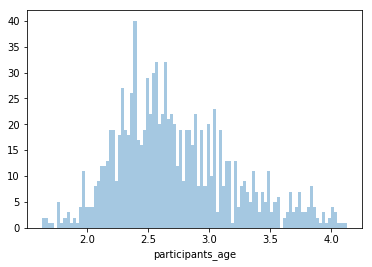

In [19]:
sns.distplot(data1['participants_age'], kde=False, bins=100)

In [20]:
cols = anatomy_cols + anatomy_sum_cols + anatomy_diff_cols

In [21]:
data1.loc[:, cols].head()

anatomy_3rd-Ventricle  anatomy_4th-Ventricle  \
subject_id                                                           
1932355398536124106                   704.9                 1643.0   
5174041730092253771                  1045.9                 2122.7   
10219322676643534800                  929.1                 2398.6   
10645466564919190227                  613.0                 1962.5   
14512541342641936232                  549.3                 1477.1   

                      anatomy_Brain-Stem  anatomy_CSF  \
subject_id                                              
1932355398536124106              18193.3        736.1   
5174041730092253771              23983.3       1065.3   
10219322676643534800             20630.9        861.4   
10645466564919190227             17555.6        602.3   
14512541342641936232             22295.6        751.4   

                      anatomy_WM-hypointensities  anatomy_Optic-Chiasm  \
subject_id                                                               
1932355398536124106                        532.4                 263.7   
5174041730092253771                        696.8                 163.0   
10219322676643534800                       722.2                 205.0   
10645466564919190227                      1447.7                 170.1   
14512541342641936232                       769.5                 162.8   

                      anatomy_CC_Posterior  anatomy_CC_Mid_Posterior  \
subject_id                                                             
1932355398536124106                  757.6                     462.6   
5174041730092253771                  902.0                     603.0   
10219322676643534800                 885.8                     540.0   
10645466564919190227                 692.2                     566.3   
14512541342641936232                1119.3                     598.0   

                      anatomy_CC_Central  anatomy_CC_Mid_Anterior  \
subject_id                                                          
1932355398536124106                446.1                    400.8   
5174041730092253771                527.4                    507.9   
10219322676643534800               763.9                    808.7   
10645466564919190227               557.2                    451.3   
14512541342641936232               951.8                   1020.0   

                                                             ...                                           \
subject_id                                                   ...                                            
1932355398536124106                                          ...                                            
5174041730092253771                                          ...                                            
10219322676643534800                                         ...                                            
10645466564919190227                                         ...                                            
14512541342641936232                                         ...                                            

                      (anatomy_lh_superiorparietal_area - anatomy_rh_superiorparietal_area)  \
subject_id                                                                                    
1932355398536124106                                               161.0                       
5174041730092253771                                                48.0                       
10219322676643534800                                              -73.0                       
10645466564919190227                                             -533.0                       
14512541342641936232                                              285.0                       

                      (anatomy_lh_superiorparietal_thickness - anatomy_rh_superiorparietal_thickness)  \
subject_id                                                                              

In [22]:
# unit_mm2_cols = [c for c in cols if re.match(r".+(area|Area)", c) and not "WhiteSurfArea" in c]

# len(unit_mm2_cols), unit_mm2_cols[:10]

In [23]:
# reg_exp = r".+(_CC|Ventricle|Inf-Lat-Vent|CSF|Chiasm|WM|VentralDC)"
# unit_mm3_a_cols = [c for c in cols if re.match(reg_exp, c)]
# len(unit_mm3_a_cols), unit_mm3_a_cols

In [24]:
# reg_exp = r".+(Vol|eTIV|Brain-Stem|White-Matter|Cortex|WhiteSurfArea)"
# unit_mm3_b_cols = [c for c in cols if re.match(reg_exp, c)]
# len(unit_mm3_b_cols), unit_mm3_b_cols

In [25]:
# set(unit_mm3_a_cols) & set(unit_mm2_cols)

In [26]:
# set(unit_mm3_b_cols) & set(unit_mm2_cols)

In [27]:
# sns.distplot(data1[unit_mm3_a_cols].values.ravel(), kde=False, bins=100)
# plt.yscale('log')

In [28]:
# sns.distplot(data1[unit_mm3_b_cols].values.ravel(), kde=False, bins=100)
# plt.yscale('log')

In [29]:
# unit_mm_cols = [c for c in cols if re.match(r".+(thickness)", c)]
# len(unit_mm_cols), unit_mm_cols[:10]

In [30]:
# set(unit_mm_cols) & set(unit_mm2_cols), set(unit_mm_cols) & set(unit_mm3_a_cols) & set(unit_mm3_b_cols)

In [31]:
# sns.distplot(data1[unit_mm_cols].values.ravel(), kde=False, bins=100)
# # plt.yscale('log')

In [32]:
# other_cols = list(set(cols) - set(unit_mm_cols) - set(unit_mm2_cols) - set(unit_mm3_a_cols) - set(unit_mm3_b_cols))

In [33]:
# sns.distplot(data1[other_cols].values.ravel(), kde=False, bins=100)
# plt.yscale('log')

In [34]:
# sns.distplot(data1['(anatomy_lh_WhiteSurfArea_area + anatomy_rh_WhiteSurfArea_area)'].values.ravel(), kde=False, bins=100)

Normalize by sum of same features

In [35]:
anatomy_cols_group_1 = [c for c in anatomy_cols if re.match(r".+(Optic|CC|Ventricle|CSF|WM)", c)]

data1.loc[5174041730092253771, anatomy_cols_group_1].sort_values()

anatomy_Optic-Chiasm             163
anatomy_CC_Mid_Anterior        507.9
anatomy_CC_Central             527.4
anatomy_CC_Mid_Posterior         603
anatomy_WM-hypointensities     696.8
anatomy_CC_Posterior             902
anatomy_CC_Anterior           1044.4
anatomy_3rd-Ventricle         1045.9
anatomy_CSF                   1065.3
anatomy_4th-Ventricle         2122.7
Name: 5174041730092253771, dtype: object

In [36]:
anatomy_cols_group_2 = [c for c in anatomy_cols if re.match(r".+(Vol|Stem|eTIV)", c)]

data1.loc[5174041730092253771, anatomy_cols_group_2].sort_values()

anatomy_Brain-Stem                      23983.3
anatomy_SubCortGrayVol                    70140
anatomy_TotalGrayVol                     759506
anatomy_SupraTentorialVolNotVent    1.18377e+06
anatomy_SupraTentorialVol           1.19967e+06
anatomy_BrainSegVolNotVent          1.32934e+06
anatomy_BrainSegVolNotVentSurf      1.32935e+06
anatomy_BrainSegVol                 1.34941e+06
anatomy_eTIV                        1.74968e+06
Name: 5174041730092253771, dtype: object

In [37]:
# set(anatomy_cols) - set(anatomy_cols_group_1) - set(anatomy_cols_group_2)

In [38]:
reg_exp = "Inf-Lat-Vent|choroid-plexus|Amygdala|Pallidum|Caudate|Hippocampus|VentralDC|Putamen|Lateral-Ventricle|Thalamus-Proper"
anatomy_sum_cols_group_1 = [c for c in anatomy_sum_cols if re.match(r".+({})".format(reg_exp), c)]

data1.loc[5174041730092253771, anatomy_sum_cols_group_1].sort_values()

(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)               344.05
(anatomy_Left-choroid-plexus + anatomy_Right-choroid-plexus)              533
(anatomy_Left-Amygdala + anatomy_Right-Amygdala)                      2027.25
(anatomy_Left-Pallidum + anatomy_Right-Pallidum)                       2422.2
(anatomy_Left-Caudate + anatomy_Right-Caudate)                        4219.45
(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)                4647.15
(anatomy_Left-VentralDC + anatomy_Right-VentralDC)                     4768.6
(anatomy_Left-Putamen + anatomy_Right-Putamen)                        6251.85
(anatomy_Left-Lateral-Ventricle + anatomy_Right-Lateral-Ventricle)     7283.4
(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)         9147.2
Name: 5174041730092253771, dtype: object

In [39]:
reg_exp = "Inf-Lat-Vent|choroid-plexus|Amygdala|Pallidum|Caudate|Hippocampus|VentralDC|Putamen|Lateral-Ventricle|Thalamus-Proper"
anatomy_diff_cols_group_1 = [c for c in anatomy_diff_cols if re.match(r".+({})".format(reg_exp), c)]

data1.loc[5174041730092253771, anatomy_diff_cols_group_1].sort_values()


(anatomy_Left-Lateral-Ventricle - anatomy_Right-Lateral-Ventricle)     -836
(anatomy_Left-Hippocampus - anatomy_Right-Hippocampus)               -726.1
(anatomy_Left-VentralDC - anatomy_Right-VentralDC)                   -553.2
(anatomy_Left-Amygdala - anatomy_Right-Amygdala)                     -453.9
(anatomy_Left-choroid-plexus - anatomy_Right-choroid-plexus)         -154.2
(anatomy_Left-Caudate - anatomy_Right-Caudate)                       -118.9
(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)                5.9
(anatomy_Left-Putamen - anatomy_Right-Putamen)                         24.5
(anatomy_Left-Thalamus-Proper - anatomy_Right-Thalamus-Proper)        105.6
(anatomy_Left-Pallidum - anatomy_Right-Pallidum)                      199.6
Name: 5174041730092253771, dtype: object

In [40]:
reg_exp = "Vol|Cortex|White-Matter"
anatomy_sum_cols_group_2 = [c for c in anatomy_sum_cols if re.match(r".+({})".format(reg_exp), c)]

data1.loc[5174041730092253771, anatomy_sum_cols_group_2].sort_values()

(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)      15352
(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)                58329.6
(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol)              269837
(anatomy_lhCortexVol + anatomy_rhCortexVol)                                        286038
Name: 5174041730092253771, dtype: object

In [41]:
reg_exp = "Vol|Cortex|White-Matter"
anatomy_diff_cols_group_2 = [c for c in anatomy_diff_cols if re.match(r".+({})".format(reg_exp), c)]

data1.loc[5174041730092253771, anatomy_diff_cols_group_2].sort_values()

(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)            -2941.57
(anatomy_lhCortexVol - anatomy_rhCortexVol)                                      -2709.31
(anatomy_Left-Cerebellum-Cortex - anatomy_Right-Cerebellum-Cortex)                -2632.3
(anatomy_Left-Cerebellum-White-Matter - anatomy_Right-Cerebellum-White-Matter)     1521.4
Name: 5174041730092253771, dtype: object

In [42]:
anatomy_sum_cols_group_3 = [c for c in anatomy_sum_cols if "area" in c]


data1.loc[5174041730092253771, anatomy_sum_cols_group_3].sort_values()


(anatomy_lh_frontalpole_area + anatomy_rh_frontalpole_area)                                 287
(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)                 373.5
(anatomy_lh_entorhinal_area + anatomy_rh_entorhinal_area)                                   437
(anatomy_lh_temporalpole_area + anatomy_rh_temporalpole_area)                             525.5
(anatomy_lh_parahippocampal_area + anatomy_rh_parahippocampal_area)                         686
(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)                             745.65
(anatomy_lh_caudalanteriorcingulate_area + anatomy_rh_caudalanteriorcingulate_area)       820.5
(anatomy_lh_rostralanteriorcingulate_area + anatomy_rh_rostralanteriorcingulate_area)       858
(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)                            1011
(anatomy_lh_bankssts_area + anatomy_rh_bankssts_area)                                      1102
(anatomy_lh_isthmuscingulate_area + anat

In [43]:
anatomy_diff_cols_group_3 = [c for c in anatomy_diff_cols if "area" in c]


data1.loc[5174041730092253771, anatomy_diff_cols_group_3].sort_values()


(anatomy_lh_WhiteSurfArea_area - anatomy_rh_WhiteSurfArea_area)                         -1203
(anatomy_lh_inferiorparietal_area - anatomy_rh_inferiorparietal_area)                    -762
(anatomy_lh_superiorfrontal_area - anatomy_rh_superiorfrontal_area)                      -675
(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)                    -494
(anatomy_lh_lateraloccipital_area - anatomy_rh_lateraloccipital_area)                    -493
(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)            -457
(anatomy_lh_pericalcarine_area - anatomy_rh_pericalcarine_area)                          -395
(anatomy_lh_lingual_area - anatomy_rh_lingual_area)                                      -351
(anatomy_lh_posteriorcingulate_area - anatomy_rh_posteriorcingulate_area)                -306
(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)                          -266
(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) 

In [44]:
anatomy_sum_cols_group_4 = [c for c in anatomy_sum_cols if "thickness" in c]

data1.loc[5174041730092253771, anatomy_sum_cols_group_4].sort_values()

(anatomy_lh_pericalcarine_thickness + anatomy_rh_pericalcarine_thickness)                            1.865
(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)                                         2.0225
(anatomy_lh_lingual_thickness + anatomy_rh_lingual_thickness)                                       2.1095
(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)                               2.2595
(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)                       2.35
(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)                     2.3735
(anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)              2.485
(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)               2.4935
(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)                     2.5315
(anatomy_lh_precuneus_thickness + ana

In [45]:
anatomy_diff_cols_group_4 = [c for c in anatomy_diff_cols if "thickness" in c]

data1.loc[5174041730092253771, anatomy_diff_cols_group_4].sort_values()

(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)                                 -0.279
(anatomy_lh_parsopercularis_thickness - anatomy_rh_parsopercularis_thickness)                       -0.202
(anatomy_lh_pericalcarine_thickness - anatomy_rh_pericalcarine_thickness)                           -0.184
(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness)                     -0.179
(anatomy_lh_isthmuscingulate_thickness - anatomy_rh_isthmuscingulate_thickness)                     -0.169
(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)                     -0.166
(anatomy_lh_fusiform_thickness - anatomy_rh_fusiform_thickness)                                     -0.138
(anatomy_lh_insula_thickness - anatomy_rh_insula_thickness)                                         -0.115
(anatomy_lh_parsorbitalis_thickness - anatomy_rh_parsorbitalis_thickness)                           -0.084
(anatomy_lh_parahippocampal_thickness

In [46]:
# anatomy_sum_cols_group_5 = list(set(anatomy_sum_cols) - set(anatomy_sum_cols_group_1) - set(anatomy_sum_cols_group_2) - set(anatomy_sum_cols_group_3) - set(anatomy_sum_cols_group_4))
# Ignore 
# (anatomy_Left-vessel + anatomy_Right-vessel)           48
# (anatomy_lhSurfaceHoles + anatomy_rhSurfaceHoles)    49.5

In [47]:
anatomy_group_1 = anatomy_cols_group_1 + anatomy_sum_cols_group_1
anatomy_group_2 = anatomy_cols_group_2 + anatomy_sum_cols_group_2
anatomy_group_3 = anatomy_sum_cols_group_3
anatomy_group_4 = anatomy_sum_cols_group_4

In [48]:
anatomy_group_1_factors = data1[anatomy_group_1].sum(axis=1)
anatomy_group_2_factors = data1[anatomy_group_2].sum(axis=1)
anatomy_group_3_factors = data1[anatomy_group_3].sum(axis=1)
anatomy_group_4_factors = data1[anatomy_group_4].sum(axis=1)

Scale by sum of groups

In [51]:
data1s = data1.copy()


# data1 = data1r.copy()

In [52]:
for c in anatomy_group_1 + anatomy_diff_cols_group_1:
    data1s.loc[:, c] = data1.loc[:, c] / anatomy_group_1_factors

for c in anatomy_group_2 + anatomy_diff_cols_group_2:
    data1s.loc[:, c] = data1.loc[:, c] / anatomy_group_2_factors

for c in anatomy_group_3 + anatomy_diff_cols_group_3:
    data1s.loc[:, c] = data1.loc[:, c] / anatomy_group_3_factors

for c in anatomy_group_4 + anatomy_diff_cols_group_4:
    data1s.loc[:, c] = data1.loc[:, c] / anatomy_group_4_factors

In [51]:
# Scale anatomy columns:
# - mm -> mm => * 1e0
# - mm^2 -> meters^2 => * 1e-4
# - mm^3 -> meters^3 => * 1e-6
# - others => * 1e-4

# for c in unit_mm_cols:
#     data1.loc[:, c] = data1[c] * 1e0
        
# for c in unit_mm2_cols:
#     data1.loc[:, c] = data1[c] * 1e-4    

# for c in unit_mm3_a_cols:
#     data1.loc[:, c] = data1[c] * 1e-5

# for c in unit_mm3_b_cols:
#     data1.loc[:, c] = data1[c] * 1e-6
        
# for c in other_cols:
#     data1.loc[:, c] = data1[c] * 1e-4

In [50]:
data1[cols].columns[(data1[cols] > 0.4).any(axis=0)]

Index([], dtype='object')

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


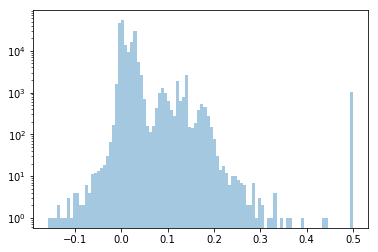

In [53]:
sns.distplot(data1s[cols].values.ravel(), kde=False, bins=100)
plt.yscale('log')

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


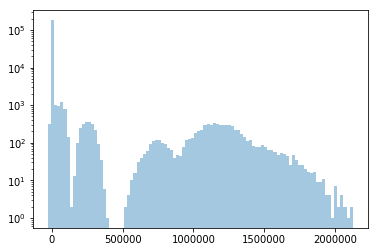

In [54]:
sns.distplot(data1[cols].values.ravel(), kde=False, bins=100)
plt.yscale('log')

In [55]:
data1s[cols].head()

anatomy_3rd-Ventricle  anatomy_4th-Ventricle  \
subject_id                                                           
1932355398536124106                0.018623               0.043407   
5174041730092253771                0.020784               0.042182   
10219322676643534800               0.022423               0.057887   
10645466564919190227               0.015120               0.048406   
14512541342641936232               0.012716               0.034193   

                      anatomy_Brain-Stem  anatomy_CSF  \
subject_id                                              
1932355398536124106             0.002389     0.019447   
5174041730092253771             0.002492     0.021169   
10219322676643534800            0.002667     0.020789   
10645466564919190227            0.002045     0.014856   
14512541342641936232            0.002447     0.017394   

                      anatomy_WM-hypointensities  anatomy_Optic-Chiasm  \
subject_id                                                               
1932355398536124106                     0.014066              0.006967   
5174041730092253771                     0.013847              0.003239   
10219322676643534800                    0.017429              0.004947   
10645466564919190227                    0.035708              0.004196   
14512541342641936232                    0.017813              0.003769   

                      anatomy_CC_Posterior  anatomy_CC_Mid_Posterior  \
subject_id                                                             
1932355398536124106               0.020015                  0.012222   
5174041730092253771               0.017924                  0.011983   
10219322676643534800              0.021378                  0.013032   
10645466564919190227              0.017074                  0.013968   
14512541342641936232              0.025910                  0.013843   

                      anatomy_CC_Central  anatomy_CC_Mid_Anterior  \
subject_id                                                          
1932355398536124106             0.011786                 0.010589   
5174041730092253771             0.010480                 0.010093   
10219322676643534800            0.018436                 0.019517   
10645466564919190227            0.013744                 0.011132   
14512541342641936232            0.022033                 0.023612   

                                                             ...                                           \
subject_id                                                   ...                                            
1932355398536124106                                          ...                                            
5174041730092253771                                          ...                                            
10219322676643534800                                         ...                                            
10645466564919190227                                         ...                                            
14512541342641936232                                         ...                                            

                      (anatomy_lh_superiorparietal_area - anatomy_rh_superiorparietal_area)  \
subject_id                                                                                    
1932355398536124106                                            0.000983                       
5174041730092253771                                            0.000247                       
10219322676643534800                                          -0.000414                       
10645466564919190227                                          -0.002846                       
14512541342641936232                                           0.001483                       

                      (anatomy_lh_superiorparietal_thickness - anatomy_rh_superiorparietal_thickness)  \
subject_id                                                                              

In [57]:
# sns.distplot(data1['anatomy_CC_Posterior'].values.ravel(), kde=False, bins=100)

### Feature extraction and filtering

In [58]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(20, 10))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    if feature_names is not None:
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

### Single features filtering by model feature importance

In [59]:
cols = anatomy_cols + anatomy_diff_cols + anatomy_sum_cols + participant_cols

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

n_jobs=1
seed = 42
        
log_reg = LogisticRegression(random_state=seed)
pipe = make_pipeline(StandardScaler(), log_reg)
    
pipe.fit(data1.loc[is_train, cols], data1.loc[is_train, 'target'])

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

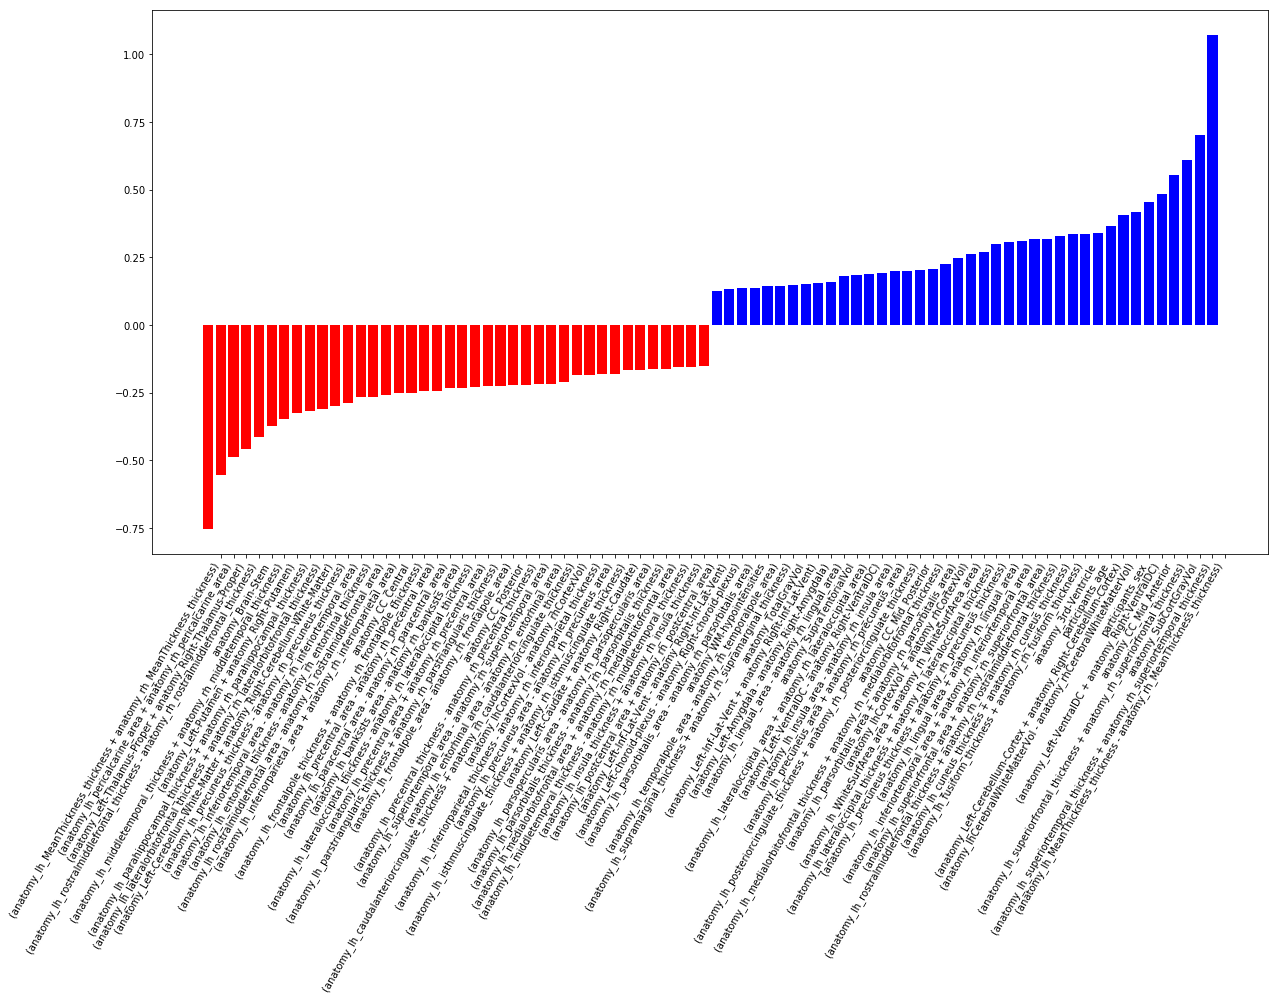

In [61]:
visualize_coefficients(log_reg, feature_names=cols, n_top_features=40)

In [62]:
coef = log_reg.coef_.ravel()

In [63]:
coef.min(), coef.max(), np.abs(coef).min()

(-0.7532346679489582, 1.0717980699493475, 0.000992176593935364)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


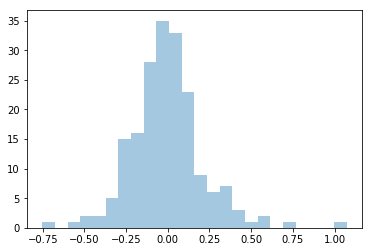

In [64]:
sns.distplot(coef, kde=False)

In [65]:
from itertools import product

In [94]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold


seed = 90
       

class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
    

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(
                                StandardScaler(),
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(
                                 StandardScaler(),
                                 LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Grid search

In [95]:
neg_thresholds = np.linspace(-0.15, -0.25, 12)
pos_thresholds = np.linspace(0.15, 0.25, 12)

In [96]:
best_roc = 0.0
best_thresholds = None
max_early_stopping = 60
c = max_early_stopping

for i, (neg_threshold, pos_threshold) in enumerate(product(neg_thresholds, pos_thresholds)):
    print("Trial: ", i, neg_threshold, pos_threshold, end=" -> ")
    positive_coefficients = np.where(coef > pos_threshold)[0]
    negative_coefficients = np.where(coef < neg_threshold)[0]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    top_1_selected_columns = np.array(cols)[interesting_coefficients].tolist()
        
    results = evaluation(data1.loc[is_train, top_1_selected_columns], data1.loc[is_train, 'target'], verbose=False)
    
    current_roc = np.mean(results['test_roc_auc'])
    print(current_roc)
    c -= 1
    if current_roc > best_roc:
        best_thresholds = (neg_threshold, pos_threshold)
        best_roc = current_roc
        c = max_early_stopping
    
    if c == 0:
        print("Stop by early stopping")
        break

In [69]:
# best_thresholds = (-0.1590909090909091, 0.1590909090909091)
best_thresholds

(-0.1590909090909091, 0.1590909090909091)

In [70]:
# neg_threshold = 0.27 * coef.min()
# pos_threshold = 0.127 * coef.max()
neg_threshold, pos_threshold = best_thresholds
print(neg_threshold, pos_threshold)

positive_coefficients = np.where(coef > pos_threshold)[0]
negative_coefficients = np.where(coef < neg_threshold)[0]

print(len(positive_coefficients), len(negative_coefficients), len(coef))

interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
top_1_selected_columns = np.array(cols)[interesting_coefficients].tolist()

results = evaluation(data1.loc[is_train, top_1_selected_columns], data1.loc[is_train, 'target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

-0.1590909090909091 0.1590909090909091
30 37 191
Training score ROC-AUC: 0.831 +- 0.007
Validation score ROC-AUC: 0.719 +- 0.016 

Training score accuracy: 0.752 +- 0.013
Validation score accuracy: 0.663 +- 0.019


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished



```
-0.1590909090909091 0.1590909090909091
30 37 191
Training score ROC-AUC: 0.831 +- 0.007
Validation score ROC-AUC: 0.719 +- 0.016 

Training score accuracy: 0.752 +- 0.013
Validation score accuracy: 0.663 +- 0.019
```

In [71]:
print("[", end="")
for f in top_1_selected_columns:
    print("\"{}\"".format(f), end=", ")
print("]")

["anatomy_Brain-Stem", "anatomy_CC_Posterior", "anatomy_CC_Central", "(anatomy_lhCortexVol - anatomy_rhCortexVol)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_parsorbitalis_thickness - anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_precuneus_area - anatomy_rh_precuneus

In [65]:


f1_columns = ["anatomy_Brain-Stem", "anatomy_CC_Posterior", "anatomy_CC_Central", "(anatomy_lhCortexVol - anatomy_rhCortexVol)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_parsorbitalis_thickness - anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_precuneus_area - anatomy_rh_precuneus_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_Left-Caudate + anatomy_Right-Caudate)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_Left-Putamen + anatomy_Right-Putamen)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_caudalanteriorcingulate_thickness + anatomy_rh_caudalanteriorcingulate_thickness)", "(anatomy_lh_frontalpole_thickness + anatomy_rh_frontalpole_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_isthmuscingulate_thickness + anatomy_rh_isthmuscingulate_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "anatomy_3rd-Ventricle", "anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Anterior", "anatomy_SubCortGrayVol", "anatomy_SupraTentorialVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_WhiteSurfArea_area + anatomy_rh_WhiteSurfArea_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "participants_sex", "participants_age", ]

len(f1_columns)


67

In [60]:


_f1_columns = ["anatomy_Brain-Stem", "anatomy_BrainSegVol", "anatomy_MaskVol", "anatomy_BrainSegVolNotVent", "(anatomy_lhCortexVol - anatomy_rhCortexVol)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "anatomy_3rd-Ventricle", "anatomy_CSF", "anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Anterior", "anatomy_CC_Anterior", "anatomy_SubCortGrayVol", "anatomy_MaskVol-to-eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "participants_sex", "participants_age", ]

len(_f1_columns)


77

In [57]:
# set(f1_columns) - set(_f1_columns)

In [81]:
results = evaluation(data1[f1_columns], data1['target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                             np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.833 +- 0.016
Validation score ROC-AUC: 0.707 +- 0.023 

Training score accuracy: 0.754 +- 0.020
Validation score accuracy: 0.657 +- 0.021


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.4s finished


In [80]:
results = evaluation(data1[_f1_columns], data1['target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                             np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.835 +- 0.013
Validation score ROC-AUC: 0.709 +- 0.016 

Training score accuracy: 0.763 +- 0.016
Validation score accuracy: 0.657 +- 0.016


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.9s finished


In [58]:
# _cols = [c for c in f1_columns if " - " in c]
# sns.distplot(data1.loc[:, _cols].values.ravel(), kde=False, bins=100)
# plt.yscale('log')

Polynomial 2nd degree



In [66]:
train_columns = f1_columns
# train_columns = anatomy_cols + anatomy_diff_cols + anatomy_sum_cols + participant_cols

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


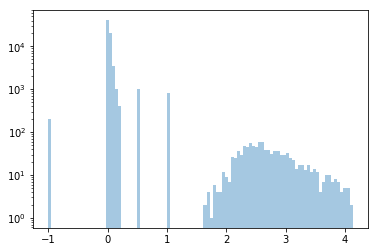

In [67]:
sns.distplot(data1s[f1_columns].values.ravel(), kde=False, bins=100)
plt.yscale('log')

In [68]:
data_ = data1s[train_columns].values
data_.shape

(1031, 67)

In [69]:
pairs_columns = []

n = len(train_columns) * (len(train_columns) - 1)
pairs_data = np.zeros((len(data_), n))

c = 0
for i, f1 in enumerate(train_columns):    
    for j, f2 in enumerate(train_columns):
        if i < j:
                        
            pairs_columns.append("{} x {}".format(f1, f2))
            pairs_data[:, c] = data_[:, i] * data_[:, j]
            c += 1
            
            pairs_columns.append("{} / {}".format(f1, f2))
            pairs_data[:, c] = data_[:, i] / (data_[:, j] + 2.0)
            c += 1

In [70]:
pairs_df = pd.DataFrame(pairs_data, columns=pairs_columns, index=data1.index)

In [71]:
pairs_columns = pairs_df.columns.values.tolist()
pairs_df.shape

(1031, 4422)

In [72]:
data2 = pd.concat([data1, pairs_df], axis=1)

In [73]:
train_columns = anatomy_cols + anatomy_diff_cols + anatomy_sum_cols + participant_cols + pairs_columns
len(train_columns)

4613

In [74]:
data2[train_columns].head()

anatomy_3rd-Ventricle  anatomy_4th-Ventricle  \
subject_id                                                           
1932355398536124106                   704.9                 1643.0   
5174041730092253771                  1045.9                 2122.7   
10219322676643534800                  929.1                 2398.6   
10645466564919190227                  613.0                 1962.5   
14512541342641936232                  549.3                 1477.1   

                      anatomy_Brain-Stem  anatomy_CSF  \
subject_id                                              
1932355398536124106              18193.3        736.1   
5174041730092253771              23983.3       1065.3   
10219322676643534800             20630.9        861.4   
10645466564919190227             17555.6        602.3   
14512541342641936232             22295.6        751.4   

                      anatomy_WM-hypointensities  anatomy_Optic-Chiasm  \
subject_id                                                               
1932355398536124106                        532.4                 263.7   
5174041730092253771                        696.8                 163.0   
10219322676643534800                       722.2                 205.0   
10645466564919190227                      1447.7                 170.1   
14512541342641936232                       769.5                 162.8   

                      anatomy_CC_Posterior  anatomy_CC_Mid_Posterior  \
subject_id                                                             
1932355398536124106                  757.6                     462.6   
5174041730092253771                  902.0                     603.0   
10219322676643534800                 885.8                     540.0   
10645466564919190227                 692.2                     566.3   
14512541342641936232                1119.3                     598.0   

                      anatomy_CC_Central  anatomy_CC_Mid_Anterior  \
subject_id                                                          
1932355398536124106                446.1                    400.8   
5174041730092253771                527.4                    507.9   
10219322676643534800               763.9                    808.7   
10645466564919190227               557.2                    451.3   
14512541342641936232               951.8                   1020.0   

                                     ...                   \
subject_id                           ...                    
1932355398536124106                  ...                    
5174041730092253771                  ...                    
10219322676643534800                 ...                    
10645466564919190227                 ...                    
14512541342641936232                 ...                    

                      (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x participants_sex  \
subject_id                                                                                                               
1932355398536124106                                           -0.030862                                                  
5174041730092253771                                            0.030068                                                  
10219322676643534800                                          -0.030166                                                  
10645466564919190227                                          -0.028994                                                  
14512541342641936232                                           0.032050                                                  

                      (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) / participants_sex  \
subject_id                                                                                                               
1932355398536124106                                            0.030862                         

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


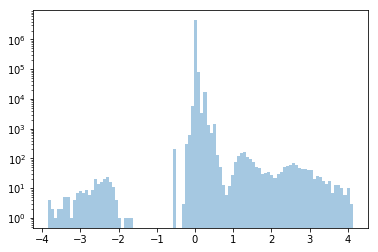

In [75]:
sns.distplot(data2[pairs_columns].values.ravel(), kde=False, bins=100)
plt.yscale('log')

In [121]:
# for c in pairs_columns:
#     mean = data2.loc[is_train, c].mean(axis=0)
#     std = data2.loc[is_train, c].std(axis=0)
#     data2.loc[:, c] = (data2[c] - mean) / (std + 1e-10)

### Double features filtering by model feature importance

In [122]:
cols = pairs_columns

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

n_jobs=1
seed = 42
        
log_reg = LogisticRegression(random_state=seed)
pipe = make_pipeline(StandardScaler(), log_reg)
    
pipe.fit(data2.loc[is_train, cols], data2.loc[is_train, 'target'])

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

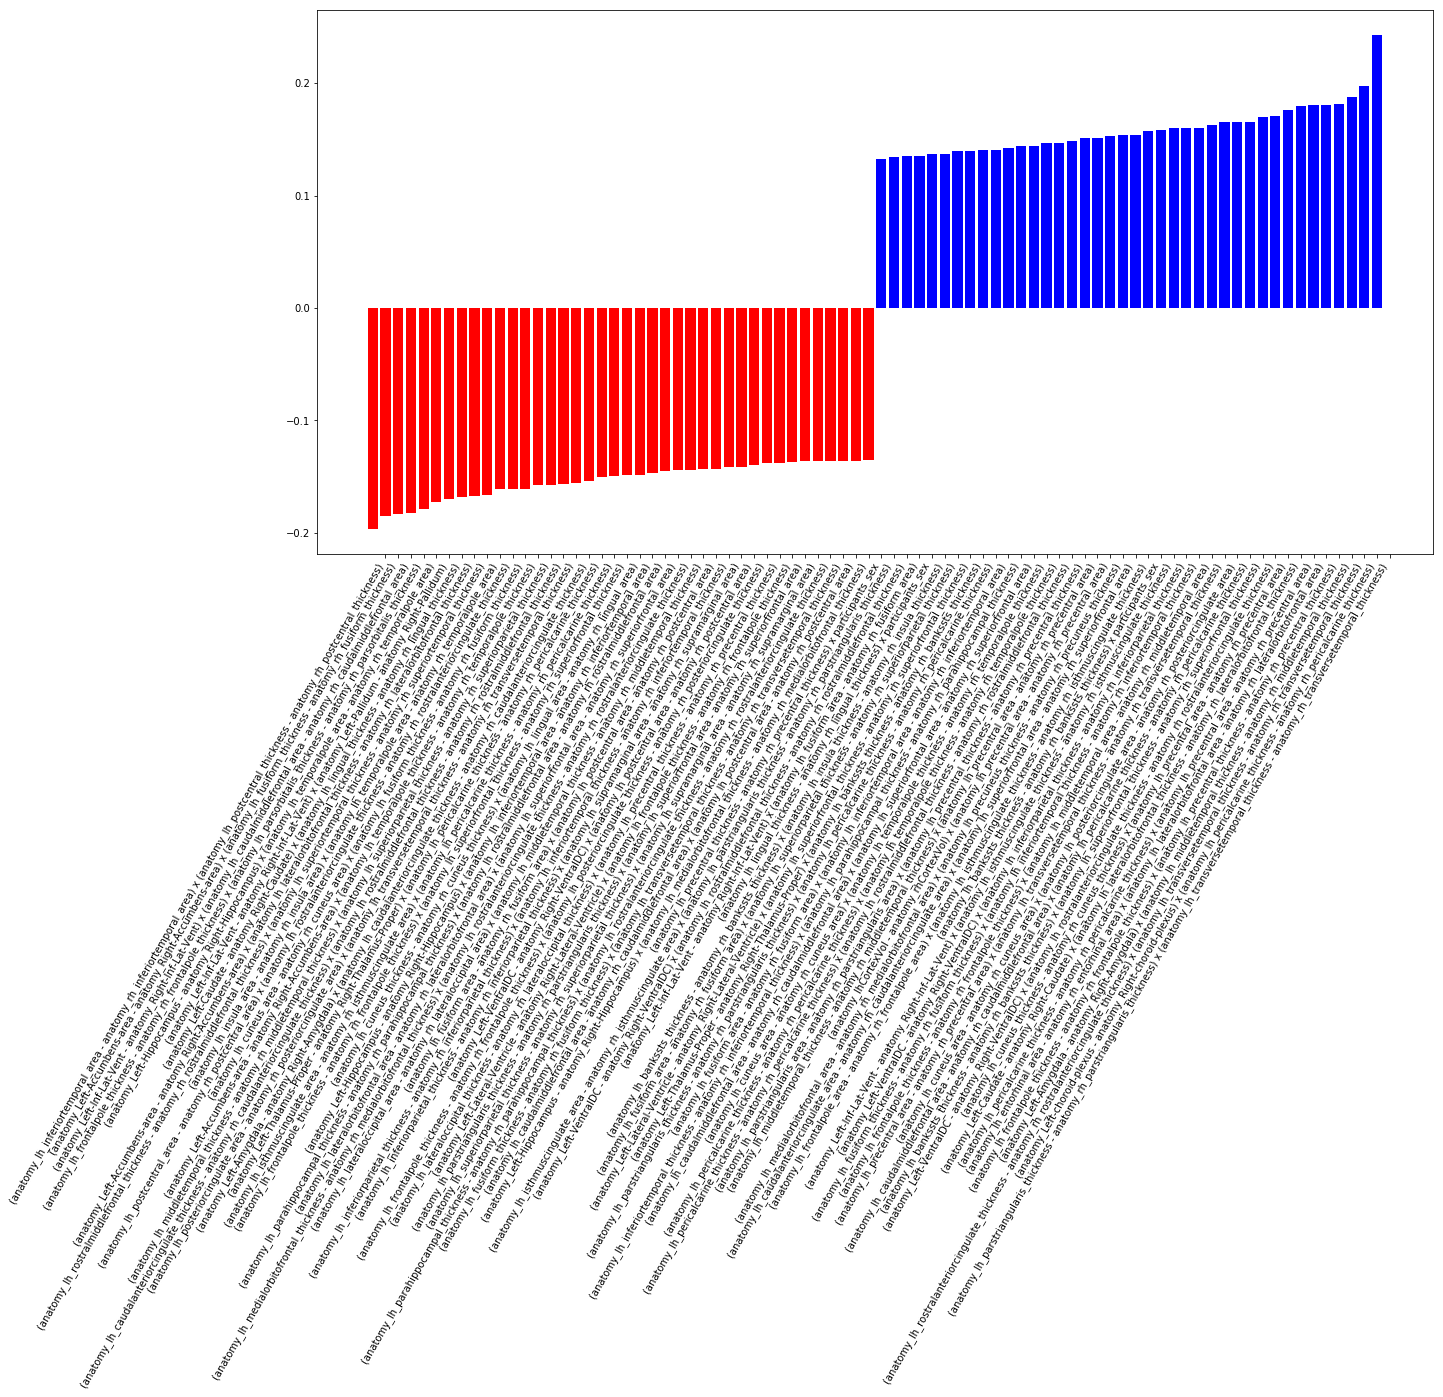

In [124]:
visualize_coefficients(log_reg, feature_names=cols, n_top_features=40)

In [125]:
coef = log_reg.coef_.ravel()

In [126]:
coef.min(), coef.max(), np.abs(coef).min()

(-0.19684658586092044, 0.24258350376087057, 3.379302946056122e-07)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


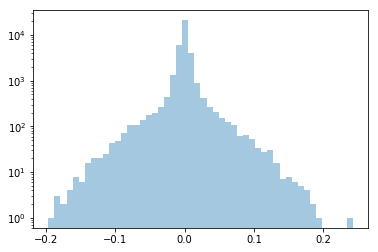

In [127]:
sns.distplot(coef, kde=False)
plt.yscale('log')

In [104]:
from itertools import product

In [105]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold


seed = 90
       

class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(),
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(),
                                 LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Grid search

In [128]:
neg_thresholds = np.linspace(-0.05, -0.12, 15)
pos_thresholds = np.linspace(0.05, 0.12, 15)

In [ ]:
best_roc = 0.0
best_thresholds = None
max_early_stopping = 60
c = max_early_stopping

for i, (neg_threshold, pos_threshold) in enumerate(product(neg_thresholds, pos_thresholds)):
    print("Trial: ", i, neg_threshold, pos_threshold, end=" -> ")
    positive_coefficients = np.where(coef > pos_threshold)[0]
    negative_coefficients = np.where(coef < neg_threshold)[0]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    top_2_selected_columns = np.array(cols)[interesting_coefficients].tolist()
        
    results = evaluation(data2.loc[is_train, top_2_selected_columns], data2.loc[is_train, 'target'], verbose=False)
    
    current_roc = np.mean(results['test_roc_auc'])
    print(current_roc)
    c -= 1
    if current_roc > best_roc:
        best_thresholds = (neg_threshold, pos_threshold)
        best_roc = current_roc
        c = max_early_stopping
    
    if c == 0:
        print("Stop by early stopping")
        break

Trial:  0 -0.05 0.05 -> 0.7077741309583808
Trial:  1 -0.05 0.055 -> 0.7119580619870778
Trial:  2 -0.05 0.06 -> 0.7134043727249966
Trial:  3 -0.05 0.065 -> 0.7128820511522147
Trial:  4 -0.05 0.07 -> 0.7107579531388301
Trial:  5 -0.05 0.075 -> 0.7068797093050165
Trial:  6 -0.05 0.08 -> 0.7098642271925131
Trial:  7 -0.05 0.08499999999999999 -> 0.7063616703477066
Trial:  8 -0.05 0.09 -> 0.7041615272186066
Trial:  9 -0.05 0.095 -> 0.7037276448093877
Trial:  10 -0.05 0.09999999999999999 -> 0.703763488731526
Trial:  11 -0.05 0.105 -> 0.7021104641028023
Trial:  12 -0.05 0.10999999999999999 -> 0.6987702421147585
Trial:  13 -0.05 0.11499999999999999 -> 0.6912468416965856
Trial:  14 -0.05 0.12 -> 0.6817901766466847
Trial:  15 -0.055 0.05 -> 0.7152312483273177
Trial:  16 -0.055 0.055 -> 0.7172660188793389
Trial:  17 -0.055 0.06 -> 0.7215527146129675
Trial:  18 -0.055 0.065 -> 0.7182615610953553
Trial:  19 -0.055 0.07 -> 0.7157496216135197
Trial:  20 -0.055 0.075 -> 0.716766421455409
Trial:  21 -0.

Process ForkPoolWorker-22456:
Process ForkPoolWorker-22449:
Process ForkPoolWorker-22452:
Process ForkPoolWorker-22454:
Traceback (most recent call last):
Process ForkPoolWorker-22451:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/pro

KeyboardInterrupt: 

In [110]:
best_thresholds

(-0.35, 0.32857142857142857)

In [111]:
# neg_threshold = 0.27 * coef.min()
# pos_threshold = 0.127 * coef.max()
neg_threshold, pos_threshold = best_thresholds
print(neg_threshold, pos_threshold)

positive_coefficients = np.where(coef > pos_threshold)[0]
negative_coefficients = np.where(coef < neg_threshold)[0]

print(len(negative_coefficients), len(positive_coefficients), len(coef))

interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
top_2_selected_columns = np.array(cols)[interesting_coefficients].tolist()

results = evaluation(data2.loc[is_train, top_2_selected_columns], data2.loc[is_train, 'target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

-0.35 0.32857142857142857
168 207 4422
Training score ROC-AUC: 0.986 +- 0.020
Validation score ROC-AUC: 0.745 +- 0.035 

Training score accuracy: 0.960 +- 0.050
Validation score accuracy: 0.680 +- 0.024



```
-0.10545454545454547 0.09090909090909091
457 347 4422
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.859 +- 0.012 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.787 +- 0.020
```

In [91]:
print("[", end="")
for f in top_2_selected_columns:
    print("\"{}\"".format(f), end=", ")
print("]")

["anatomy_Brain-Stem / anatomy_MaskVol", "anatomy_Brain-Stem x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_Brain-Stem x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "anatomy_Brain-Stem x participants_age", "anatomy_CC_Central / anatomy_MaskVol", "anatomy_CC_Central x (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "anatomy_CC_Central x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "anatomy_CC_Central x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "anatomy_CC_Central x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_CC_Central / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "anatomy_CC_Central x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_BrainSegVol x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "anatomy_BrainSegVol x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anat

In [93]:

f2_columns = ["anatomy_Brain-Stem / anatomy_MaskVol", "anatomy_Brain-Stem x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_Brain-Stem x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "anatomy_Brain-Stem x participants_age", "anatomy_CC_Central / anatomy_MaskVol", "anatomy_CC_Central x (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "anatomy_CC_Central x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "anatomy_CC_Central x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "anatomy_CC_Central x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_CC_Central / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "anatomy_CC_Central x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_BrainSegVol x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "anatomy_BrainSegVol x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_MaskVol x (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "anatomy_MaskVol x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "anatomy_MaskVol x anatomy_MaskVol-to-eTIV", "anatomy_MaskVol x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_BrainSegVolNotVent x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "anatomy_BrainSegVolNotVent x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_BrainSegVolNotVent x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_BrainSegVolNotVent x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x participants_sex", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_age", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_age", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_age", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / participants_sex", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / participants_sex", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_SubCortGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_3rd-Ventricle x anatomy_SubCortGrayVol", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_3rd-Ventricle x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_3rd-Ventricle x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_CC_Mid_Anterior x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_CC_Mid_Anterior x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_CC_Mid_Anterior x participants_sex", "anatomy_CC_Mid_Anterior x participants_age", "anatomy_MaskVol-to-eTIV x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_MaskVol-to-eTIV x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_MaskVol-to-eTIV x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "anatomy_MaskVol-to-eTIV x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x participants_age", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / participants_sex", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_sex", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "anatomy_Brain-Stem x anatomy_CC_Central", "anatomy_Brain-Stem x (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "anatomy_Brain-Stem x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "anatomy_Brain-Stem x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "anatomy_Brain-Stem x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "anatomy_Brain-Stem x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_Brain-Stem x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_CC_Central x anatomy_BrainSegVol", "anatomy_CC_Central x anatomy_BrainSegVolNotVent", "anatomy_CC_Central x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "anatomy_CC_Central x (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "anatomy_CC_Central x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_CC_Central x (anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol)", "anatomy_CC_Central x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "anatomy_CC_Central x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "anatomy_CC_Central x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "anatomy_CC_Central x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "anatomy_CC_Central x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_CC_Central x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "anatomy_CC_Central x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "anatomy_CC_Central x participants_sex", "anatomy_BrainSegVol / anatomy_BrainSegVolNotVent", "anatomy_BrainSegVol x (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "anatomy_BrainSegVol / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "anatomy_BrainSegVol / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "anatomy_BrainSegVol / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "anatomy_BrainSegVol / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "anatomy_BrainSegVol / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "anatomy_BrainSegVol / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "anatomy_BrainSegVol x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_MaskVol x (anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "anatomy_MaskVol x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "anatomy_MaskVol x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_BrainSegVolNotVent x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "anatomy_BrainSegVolNotVent x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x participants_age", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x participants_age", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x participants_sex", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x participants_sex", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_3rd-Ventricle", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_sex", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Anterior", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) / participants_sex", "(anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x participants_age", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x participants_sex", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x participants_sex", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x participants_age", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x participants_sex", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x participants_age", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x participants_age", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_3rd-Ventricle x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_3rd-Ventricle x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "anatomy_3rd-Ventricle x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "anatomy_3rd-Ventricle x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "anatomy_3rd-Ventricle x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_3rd-Ventricle x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "anatomy_3rd-Ventricle x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "anatomy_3rd-Ventricle x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "anatomy_CC_Mid_Anterior x anatomy_MaskVol-to-eTIV", "anatomy_CC_Mid_Anterior x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_CC_Mid_Anterior / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "anatomy_CC_Mid_Anterior x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "anatomy_CC_Mid_Anterior x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "anatomy_CC_Mid_Anterior / participants_sex", "anatomy_SubCortGrayVol x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "anatomy_SubCortGrayVol x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "anatomy_SubCortGrayVol x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_MaskVol-to-eTIV x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x participants_sex", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_age", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_sex", "(anatomy_lhCortexVol + anatomy_rhCortexVol) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lhCortexVol + anatomy_rhCortexVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x participants_sex", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / participants_sex", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_sex", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x participants_age", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_age", ]

len(f2_columns)


518

In [54]:

_f2_columns = ["anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol)", "anatomy_Brain-Stem / (anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "anatomy_Brain-Stem / (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "anatomy_Brain-Stem x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "anatomy_Brain-Stem / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "anatomy_Brain-Stem / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "anatomy_Brain-Stem x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "anatomy_Brain-Stem x participants_age", "anatomy_Brain-Stem / participants_age", "anatomy_BrainSegVol / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_BrainSegVol x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_BrainSegVol x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "anatomy_BrainSegVol x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "anatomy_BrainSegVol x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "anatomy_BrainSegVol x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "anatomy_MaskVol x (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "anatomy_MaskVol / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_MaskVol x anatomy_CC_Mid_Posterior", "anatomy_MaskVol x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_MaskVol x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "anatomy_MaskVol x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_MaskVol x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_BrainSegVolNotVent / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_BrainSegVolNotVent x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_BrainSegVolNotVent x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "anatomy_BrainSegVolNotVent x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x participants_age", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / participants_age", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x participants_age", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x participants_sex", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_sex", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x participants_age", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / participants_age", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / participants_age", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / participants_age", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x participants_age", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / participants_age", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / participants_age", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x participants_age", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / participants_age", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_sex", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / participants_sex", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_sex", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / participants_sex", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_SubCortGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_sex", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_age", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_sex", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / participants_sex", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x participants_age", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x participants_age", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / participants_age", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CSF", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x participants_age", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x participants_age", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / participants_age", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x participants_sex", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / participants_sex", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / participants_age", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x participants_sex", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_sex", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x participants_age", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_age", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x participants_sex", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / participants_sex", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / participants_age", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_3rd-Ventricle / anatomy_CSF", "anatomy_3rd-Ventricle x anatomy_SubCortGrayVol", "anatomy_3rd-Ventricle / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "anatomy_3rd-Ventricle / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_3rd-Ventricle / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "anatomy_3rd-Ventricle / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "anatomy_CSF x anatomy_SubCortGrayVol", "anatomy_CSF x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_CSF x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_CSF x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_CC_Mid_Posterior / anatomy_SubCortGrayVol", "anatomy_CC_Mid_Posterior x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Mid_Posterior x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_CC_Mid_Posterior x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "anatomy_CC_Mid_Posterior / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "anatomy_CC_Mid_Posterior x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_CC_Mid_Anterior / anatomy_SubCortGrayVol", "anatomy_CC_Mid_Anterior x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_CC_Mid_Anterior x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_CC_Mid_Anterior x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "anatomy_CC_Mid_Anterior x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "anatomy_CC_Mid_Anterior x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "anatomy_CC_Mid_Anterior / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "anatomy_CC_Mid_Anterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_CC_Anterior / anatomy_MaskVol-to-eTIV", "anatomy_CC_Anterior / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_CC_Anterior x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "anatomy_CC_Anterior x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "anatomy_CC_Anterior x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_CC_Anterior x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_SubCortGrayVol / anatomy_MaskVol-to-eTIV", "anatomy_SubCortGrayVol x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_SubCortGrayVol / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "anatomy_MaskVol-to-eTIV x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_MaskVol-to-eTIV / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_MaskVol-to-eTIV x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_MaskVol-to-eTIV x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_MaskVol-to-eTIV x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_MaskVol-to-eTIV x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "anatomy_MaskVol-to-eTIV x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_Brain-Stem / (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "anatomy_Brain-Stem x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "anatomy_Brain-Stem / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "anatomy_Brain-Stem / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_Brain-Stem x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "anatomy_Brain-Stem / anatomy_3rd-Ventricle", "anatomy_Brain-Stem x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_Brain-Stem x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "anatomy_Brain-Stem x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_Brain-Stem / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "anatomy_BrainSegVol / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "anatomy_BrainSegVol / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "anatomy_BrainSegVol x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "anatomy_MaskVol / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "anatomy_MaskVol / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "anatomy_MaskVol / participants_age", "anatomy_BrainSegVolNotVent / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "anatomy_BrainSegVolNotVent / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_3rd-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CSF", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_CSF", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "anatomy_3rd-Ventricle / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_3rd-Ventricle x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_3rd-Ventricle x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "anatomy_3rd-Ventricle x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_3rd-Ventricle x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "anatomy_3rd-Ventricle x participants_sex", "anatomy_3rd-Ventricle / participants_sex", "anatomy_3rd-Ventricle x participants_age", "anatomy_3rd-Ventricle / participants_age", "anatomy_CSF / anatomy_CC_Mid_Posterior", "anatomy_CSF / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "anatomy_CSF x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_CSF / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_CSF x participants_sex", "anatomy_CSF / participants_sex", "anatomy_CSF x participants_age", "anatomy_CSF / participants_age", "anatomy_CC_Mid_Posterior x anatomy_CC_Mid_Anterior", "anatomy_CC_Mid_Posterior x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_CC_Mid_Posterior / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "anatomy_CC_Mid_Posterior x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_CC_Mid_Posterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_CC_Mid_Posterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_CC_Mid_Posterior x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "anatomy_CC_Mid_Posterior / participants_age", "anatomy_CC_Mid_Anterior x anatomy_CC_Anterior", "anatomy_CC_Mid_Anterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "anatomy_CC_Mid_Anterior / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_CC_Mid_Anterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "anatomy_CC_Mid_Anterior / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_CC_Mid_Anterior / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_CC_Mid_Anterior x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "anatomy_CC_Mid_Anterior / participants_age", "anatomy_CC_Anterior / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Anterior x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_CC_Anterior x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "anatomy_CC_Anterior x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "anatomy_CC_Anterior x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "anatomy_CC_Anterior x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "anatomy_CC_Anterior / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "anatomy_CC_Anterior x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "anatomy_CC_Anterior x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "anatomy_CC_Anterior / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "anatomy_MaskVol-to-eTIV / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_MaskVol-to-eTIV / participants_age", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_age", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_age", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x participants_sex", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / participants_sex", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / participants_age", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_sex", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_sex", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_sex", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / participants_sex", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_age", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / participants_age", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x participants_age", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / participants_age", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_age", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lhCortexVol + anatomy_rhCortexVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / participants_age", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x participants_sex", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_sex", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x participants_age", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x participants_sex", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / participants_sex", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x participants_age", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / participants_age", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x participants_age", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_age", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / participants_age", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / participants_age", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x participants_age", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / participants_age", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x participants_age", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / participants_age", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) / participants_age", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_sex", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_sex", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_age", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_age", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age", "participants_sex x participants_age", "participants_sex / participants_age", ]

len(_f2_columns)


930

In [56]:
"participants_sex x participants_age" in _f2_columns

True

In [99]:
len(set(f2_columns) & set(_f2_columns))

183

In [95]:
len(f1_columns + f2_columns)

588

In [134]:
cols = [c for c in f2_columns if "age" in c]

In [135]:
cols

['anatomy_Brain-Stem x participants_age',
 '(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age',
 '(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age',
 '(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_age',
 '(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_age',
 '(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_age',
 'anatomy_CC_Mid_Anterior x participants_age',
 '(anatomy_lh_insula_area - anatomy_rh_insula_area) x participants_age',
 '(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age',
 '(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x participants_age',
 '(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x participants_age',
 '(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age',
 '(anatomy_lh_fusifo

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


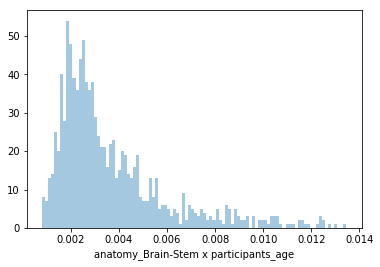

In [137]:
sns.distplot(data2['anatomy_Brain-Stem x participants_age'], kde=False, bins=100)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


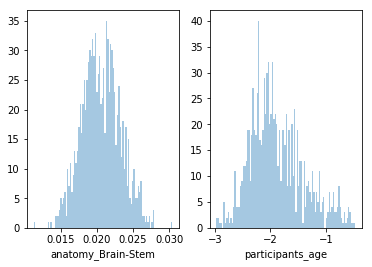

In [142]:
plt.subplot(121)
sns.distplot(data2['anatomy_Brain-Stem'], kde=False, bins=100)
plt.subplot(122)
sns.distplot(data2['participants_age'].apply(np.log), kde=False, bins=100)

In [98]:
results = evaluation(data2[f1_columns + f2_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.982 +- 0.024
Validation score ROC-AUC: 0.747 +- 0.023 

Training score accuracy: 0.948 +- 0.050
Validation score accuracy: 0.680 +- 0.022


In [100]:
results = evaluation(data2.loc[is_train, f1_columns + f2_columns], data2.loc[is_train, 'target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.992 +- 0.012
Validation score ROC-AUC: 0.762 +- 0.029 

Training score accuracy: 0.971 +- 0.037
Validation score accuracy: 0.697 +- 0.022


Polynomial 3nd degree



In [101]:
cols = [c for c in f2_columns if " + " in c or " - " in c]

In [102]:
cols[-10:]

['(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x participants_sex',
 '(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)',
 '(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / participants_sex',
 '(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)',
 '(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_sex',
 '(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)',
 '(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)',
 '(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_are

In [103]:
data_ = data2[cols].values
data_.shape

(1031, 504)

In [105]:
triplet_columns = []

n = len(cols) * (len(anatomy_cols) )

triplet_data = np.zeros((len(data_), n))

c = 0
for i, f1 in enumerate(cols):    
    for j, f2 in enumerate(anatomy_cols):
        triplet_columns.append("{} x {}".format(f1, f2))
        triplet_data[:, c] = data_[:, i] * data_[:, j]
        c += 1

In [106]:
triplet_data.shape, len(triplet_columns)

((1031, 11088), 11088)

In [107]:
triplet_df = pd.DataFrame(triplet_data, columns=triplet_columns, index=data2.index)

In [108]:
triplet_columns = triplet_df.columns.values.tolist()
triplet_df.shape

(1031, 11088)

In [109]:
data3 = pd.concat([data2, triplet_df], axis=1)

In [110]:
train_columns = anatomy_cols + anatomy_diff_cols + anatomy_sum_cols + participant_cols + pairs_columns + triplet_columns
len(train_columns)

16116

In [111]:
data3[train_columns].head()

anatomy_3rd-Ventricle  anatomy_4th-Ventricle  \
subject_id                                                           
1932355398536124106                0.007049               0.016430   
5174041730092253771                0.010459               0.021227   
10219322676643534800               0.009291               0.023986   
10645466564919190227               0.006130               0.019625   
14512541342641936232               0.005493               0.014771   

                      anatomy_Brain-Stem  anatomy_CSF  \
subject_id                                              
1932355398536124106             0.018193     0.007361   
5174041730092253771             0.023983     0.010653   
10219322676643534800            0.020631     0.008614   
10645466564919190227            0.017556     0.006023   
14512541342641936232            0.022296     0.007514   

                      anatomy_WM-hypointensities  anatomy_Optic-Chiasm  \
subject_id                                                               
1932355398536124106                     0.005324              0.002637   
5174041730092253771                     0.006968              0.001630   
10219322676643534800                    0.007222              0.002050   
10645466564919190227                    0.014477              0.001701   
14512541342641936232                    0.007695              0.001628   

                      anatomy_CC_Posterior  anatomy_CC_Mid_Posterior  \
subject_id                                                             
1932355398536124106               0.007576                  0.004626   
5174041730092253771               0.009020                  0.006030   
10219322676643534800              0.008858                  0.005400   
10645466564919190227              0.006922                  0.005663   
14512541342641936232              0.011193                  0.005980   

                      anatomy_CC_Central  anatomy_CC_Mid_Anterior  \
subject_id                                                          
1932355398536124106             0.004461                 0.004008   
5174041730092253771             0.005274                 0.005079   
10219322676643534800            0.007639                 0.008087   
10645466564919190227            0.005572                 0.004513   
14512541342641936232            0.009518                 0.010200   

                                                                                   ...                                                                 \
subject_id                                                                         ...                                                                  
1932355398536124106                                                                ...                                                                  
5174041730092253771                                                                ...                                                                  
10219322676643534800                                                               ...                                                                  
10645466564919190227                                                               ...                                                                  
14512541342641936232                                                               ...                                                                  

                      (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_age x anatomy_BrainSegVolNotVentSurf  \
subject_id                                                                                                                                                  
1932355398536124106                                            0.021114                                                                                     
5174041730092253771                                            0.008028         

### Triplet features filtering by model feature importance

In [112]:
cols = triplet_columns

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

n_jobs=1
seed = 42
        
log_reg = LogisticRegression(random_state=seed)
pipe = make_pipeline(StandardScaler(), log_reg)
    
pipe.fit(data3.loc[is_train, cols], data3.loc[is_train, 'target'])

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

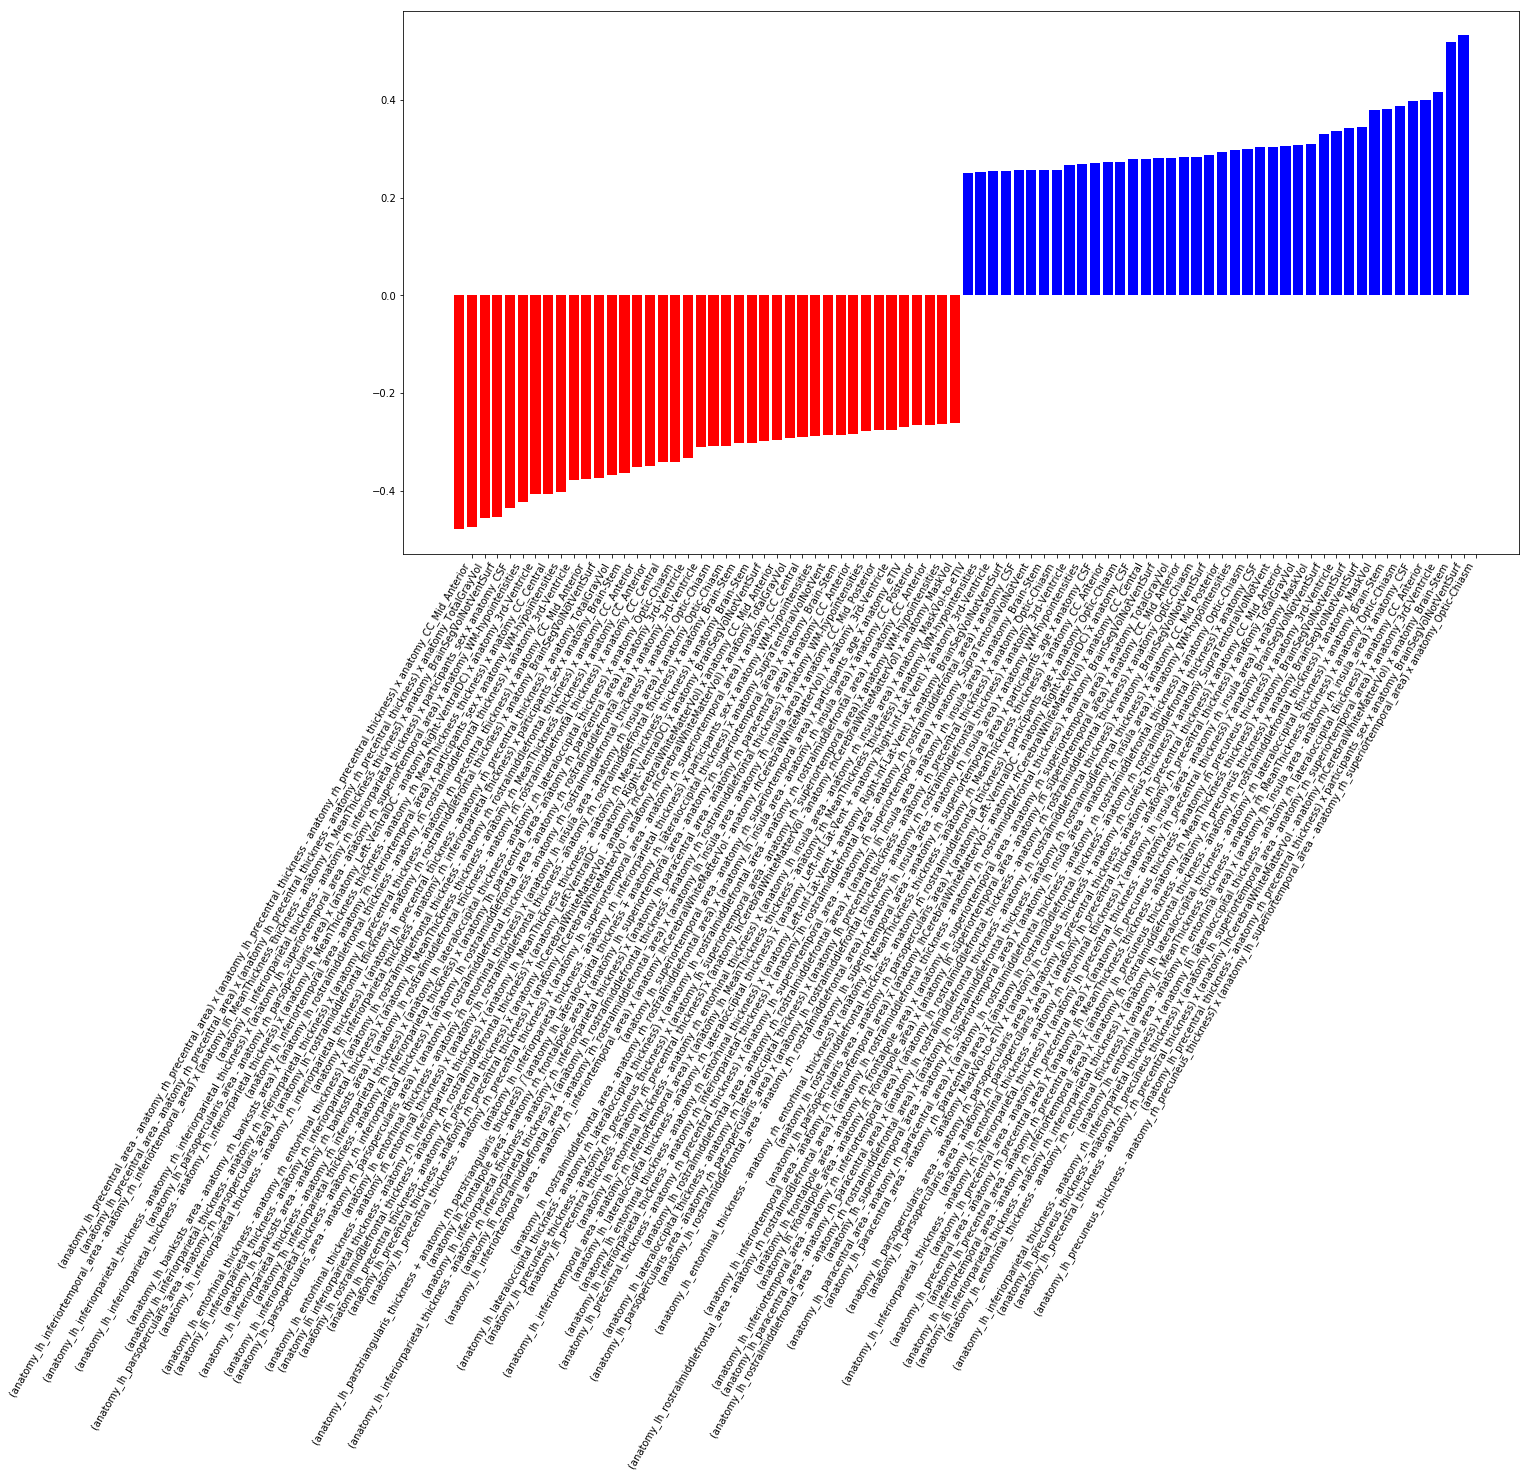

In [114]:
visualize_coefficients(log_reg, feature_names=cols, n_top_features=40)

In [115]:
coef = log_reg.coef_.ravel()

In [116]:
coef.min(), coef.max(), np.abs(coef).min()

(-0.4792388009291044, 0.532648779063811, 2.7109308933071603e-06)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


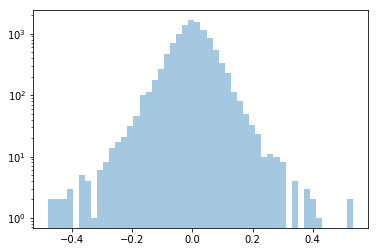

In [117]:
sns.distplot(coef, kde=False)
plt.yscale('log')

In [118]:
from itertools import product

In [119]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold

seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Grid search

In [124]:
neg_thresholds = np.linspace(-0.07, -0.15, 12)
pos_thresholds = np.linspace(0.07, 0.15, 12)

In [125]:
best_roc = 0.0
best_thresholds = None
max_early_stopping = 30
c = max_early_stopping

for i, (neg_threshold, pos_threshold) in enumerate(product(neg_thresholds, pos_thresholds)):
    print("Trial: ", i, neg_threshold, pos_threshold, end=" -> ")
    positive_coefficients = np.where(coef > pos_threshold)[0]
    negative_coefficients = np.where(coef < neg_threshold)[0]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    top_3_selected_columns = np.array(cols)[interesting_coefficients].tolist()
        
    results = evaluation(data3.loc[is_train, top_3_selected_columns], data3.loc[is_train, 'target'], verbose=False)
    
    current_roc = np.mean(results['test_roc_auc'])
    print(current_roc)
    c -= 1
    if current_roc > best_roc:
        best_thresholds = (neg_threshold, pos_threshold)
        best_roc = current_roc
        c = max_early_stopping
    
    if c == 0:
        print("Stop by early stopping")
        break

Trial:  0 -0.07 0.07 -> 0.722249451369232
Trial:  1 -0.07 0.07727272727272728 -> 0.729137959535339
Trial:  2 -0.07 0.08454545454545455 -> 0.7256039861414573
Trial:  3 -0.07 0.09181818181818183 -> 0.7299430644589778
Trial:  4 -0.07 0.09909090909090909 -> 0.724631317788819
Trial:  5 -0.07 0.10636363636363637 -> 0.7267536612989304
Trial:  6 -0.07 0.11363636363636365 -> 0.7226032708155163
Trial:  7 -0.07 0.12090909090909091 -> 0.7178565622164026
Trial:  8 -0.07 0.12818181818181817 -> 0.7043446187111463
Trial:  9 -0.07 0.13545454545454544 -> 0.702235354224292
Trial:  10 -0.07 0.14272727272727273 -> 0.7020588126164587
Trial:  11 -0.07 0.15 -> 0.6906069498977645
Trial:  12 -0.07727272727272728 0.07 -> 0.7279440369793774
Trial:  13 -0.07727272727272728 0.07727272727272728 -> 0.7346783441279521
Trial:  14 -0.07727272727272728 0.08454545454545455 -> 0.7357691159419636
Trial:  15 -0.07727272727272728 0.09181818181818183 -> 0.737664181113653
Trial:  16 -0.07727272727272728 0.09909090909090909 -> 0

In [96]:
best_thresholds

(-0.0015, 0.0015)

In [127]:
# neg_threshold = 0.27 * coef.min()
# pos_threshold = 0.127 * coef.max()
neg_threshold, pos_threshold = best_thresholds
print(neg_threshold, pos_threshold)

positive_coefficients = np.where(coef > pos_threshold)[0]
negative_coefficients = np.where(coef < neg_threshold)[0]

print(len(negative_coefficients), len(positive_coefficients), len(coef))


interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
top_3_selected_columns = np.array(cols)[interesting_coefficients].tolist()

results = evaluation(data3.loc[is_train, top_3_selected_columns], data3.loc[is_train, 'target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

-0.11363636363636365 0.10636363636363637
572 594 11088
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.762 +- 0.027 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.705 +- 0.021



```
-0.03932351273569926 0.022553479574011357
1576 716 40602

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.773 +- 0.013 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.714 +- 0.014
```

In [128]:
print("[", end="")
for f in top_3_selected_columns:
    print("\"{}\"".format(f), end=", ")
print("]")

["anatomy_CC_Central / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Mid_Posterior", "anatomy_CC_Central x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "anatomy_MaskVol x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_BrainSegVol", "anatomy_BrainSegVolNotVent x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_SupraTentorialVolNotVent", "anatomy_BrainSegVolNotVent x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Poste

In [129]:

f3_columns = ["anatomy_CC_Central / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Mid_Posterior", "anatomy_CC_Central x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "anatomy_MaskVol x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_BrainSegVol", "anatomy_BrainSegVolNotVent x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_SupraTentorialVolNotVent", "anatomy_BrainSegVolNotVent x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Central", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_BrainSegVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_SupraTentorialVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_Brain-Stem", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_WM-hypointensities", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_TotalGrayVol", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_4th-Ventricle", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_BrainSegVol", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_TotalGrayVol", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Brain-Stem", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_BrainSegVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SubCortGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_MaskVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_3rd-Ventricle x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_3rd-Ventricle x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_3rd-Ventricle x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_3rd-Ventricle x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_3rd-Ventricle x anatomy_BrainSegVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_3rd-Ventricle x anatomy_SupraTentorialVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_3rd-Ventricle x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age x anatomy_TotalGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age x anatomy_SupraTentorialVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_SupraTentorialVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_SubCortGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_SupraTentorialVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_MaskVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_3rd-Ventricle x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_BrainSegVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_MaskVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x participants_sex x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x participants_sex x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x participants_sex x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x participants_sex x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x participants_sex x anatomy_BrainSegVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x participants_sex x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x participants_sex x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x participants_sex x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x participants_sex x anatomy_MaskVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_BrainSegVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_BrainSegVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_SupraTentorialVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Anterior x anatomy_BrainSegVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Anterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_BrainSegVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_BrainSegVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_BrainSegVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_BrainSegVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_3rd-Ventricle x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_3rd-Ventricle x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_3rd-Ventricle x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_3rd-Ventricle x anatomy_SubCortGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_3rd-Ventricle x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_MaskVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_BrainSegVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior x anatomy_BrainSegVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior x anatomy_SubCortGrayVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior x anatomy_SupraTentorialVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior x anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior x anatomy_eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior x anatomy_BrainSegVolNotVent", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_BrainSegVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_SubCortGrayVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_SupraTentorialVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_age x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_age x anatomy_SubCortGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_age x anatomy_SupraTentorialVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_age x anatomy_MaskVol-to-eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_age x anatomy_eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_age x anatomy_BrainSegVolNotVent", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_BrainSegVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_BrainSegVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex x anatomy_SubCortGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_age x anatomy_BrainSegVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_age x anatomy_4th-Ventricle", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_age x anatomy_CC_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_age x anatomy_CC_Mid_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_age x anatomy_BrainSegVol", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_4th-Ventricle", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_BrainSegVol", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_BrainSegVol", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_SubCortGrayVol", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_SupraTentorialVol", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_BrainSegVol", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / participants_sex x anatomy_4th-Ventricle", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / participants_sex x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / participants_sex x anatomy_BrainSegVol", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / participants_sex x anatomy_SubCortGrayVol", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / participants_sex x anatomy_SupraTentorialVol", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / participants_sex x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_4th-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_BrainSegVol", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_SubCortGrayVol", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_SupraTentorialVol", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_4th-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_BrainSegVol", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_SupraTentorialVol", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_BrainSegVol", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_BrainSegVol", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVolNotVent", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVol", "anatomy_3rd-Ventricle x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "anatomy_3rd-Ventricle x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_3rd-Ventricle", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Anterior", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_SubCortGrayVol", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_SupraTentorialVol", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_SupraTentorialVolNotVent", "anatomy_MaskVol-to-eTIV x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Posterior", "anatomy_MaskVol-to-eTIV x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SupraTentorialVol", "anatomy_MaskVol-to-eTIV x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SupraTentorialVolNotVent", "anatomy_MaskVol-to-eTIV x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_3rd-Ventricle", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_MaskVol", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x participants_age x anatomy_WM-hypointensities", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age x anatomy_BrainSegVol", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / participants_sex x anatomy_SupraTentorialVolNotVent", "anatomy_Brain-Stem x (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_BrainSegVolNotVentSurf", "anatomy_Brain-Stem x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Posterior", "anatomy_Brain-Stem x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_BrainSegVol", "anatomy_Brain-Stem x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_SupraTentorialVolNotVent", "anatomy_Brain-Stem x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_SupraTentorialVolNotVent", "anatomy_Brain-Stem x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Posterior", "anatomy_Brain-Stem x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_SupraTentorialVolNotVent", "anatomy_Brain-Stem x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_BrainSegVol-to-eTIV", "anatomy_Brain-Stem x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_eTIV", "anatomy_Brain-Stem x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_BrainSegVolNotVent", "anatomy_CC_Central x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_WM-hypointensities", "anatomy_CC_Central x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "anatomy_BrainSegVol x (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CC_Posterior", "anatomy_BrainSegVol x (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_BrainSegVol", "anatomy_BrainSegVol x (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_SupraTentorialVolNotVent", "anatomy_BrainSegVol / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_SubCortGrayVol", "anatomy_BrainSegVol / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SubCortGrayVol", "anatomy_BrainSegVol / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVolNotVent", "anatomy_BrainSegVol x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "anatomy_MaskVol x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "anatomy_BrainSegVolNotVent x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_MaskVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CSF", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_3rd-Ventricle x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x participants_age x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x participants_age x anatomy_CSF", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x participants_age x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x anatomy_CSF", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x anatomy_MaskVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CSF", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Central", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_TotalGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_TotalGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CSF", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x anatomy_CC_Mid_Anterior x anatomy_Brain-Stem", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x participants_sex x anatomy_Brain-Stem", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x participants_sex x anatomy_CSF", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x participants_sex x anatomy_WM-hypointensities", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x participants_sex x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x participants_sex x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x participants_sex x anatomy_MaskVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x participants_sex x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x participants_sex x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CSF", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_MaskVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior x anatomy_CSF", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_MaskVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_MaskVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_MaskVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_3rd-Ventricle x anatomy_WM-hypointensities", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_sex x anatomy_WM-hypointensities", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x participants_sex x anatomy_CSF", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Brain-Stem", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_eTIV", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_3rd-Ventricle x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVol", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_eTIV", "anatomy_3rd-Ventricle x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Central", "anatomy_3rd-Ventricle x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_MaskVol", "anatomy_3rd-Ventricle x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "anatomy_CC_Mid_Anterior x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "anatomy_SubCortGrayVol x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age x anatomy_CSF", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age x anatomy_CC_Mid_Anterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age x anatomy_TotalGrayVol", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x participants_sex x anatomy_WM-hypointensities", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x participants_sex x anatomy_MaskVol", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_lhCortexVol + anatomy_rhCortexVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CSF", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CSF", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x participants_sex x anatomy_CSF", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x participants_sex x anatomy_WM-hypointensities", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_BrainSegVolNotVentSurf", "anatomy_CC_Central x (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_WM-hypointensities", "anatomy_CC_Central x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "anatomy_CC_Central x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Posterior", "anatomy_CC_Central x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "anatomy_MaskVol x (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_CC_Anterior", "anatomy_MaskVol x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_SubCortGrayVol x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_SubCortGrayVol x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness) x anatomy_CSF", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_MaskVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_TotalGrayVol", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CSF", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_WM-hypointensities", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_MaskVol", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_MaskVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_3rd-Ventricle x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age x anatomy_CSF", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CSF", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_MaskVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_eTIV", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_BrainSegVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_3rd-Ventricle x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_3rd-Ventricle x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_3rd-Ventricle x anatomy_MaskVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x participants_sex x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_3rd-Ventricle x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_MaskVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior x anatomy_MaskVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_BrainSegVolNotVent", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_age x anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_age x anatomy_WM-hypointensities", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex x anatomy_WM-hypointensities", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_age x anatomy_WM-hypointensities", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_age x anatomy_CC_Central", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / participants_sex x anatomy_CSF", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Central", "anatomy_MaskVol-to-eTIV x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Posterior", "anatomy_MaskVol-to-eTIV x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_SupraTentorialVolNotVent", "anatomy_MaskVol-to-eTIV x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_eTIV", "anatomy_MaskVol-to-eTIV x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Posterior", "anatomy_MaskVol-to-eTIV x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Posterior", "anatomy_MaskVol-to-eTIV x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_4th-Ventricle", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Central", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Central", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x participants_age x anatomy_MaskVol", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_BrainSegVol", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SupraTentorialVol", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_CC_Central", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Posterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age x anatomy_CC_Central", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_TotalGrayVol", "anatomy_CC_Central x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "anatomy_CC_Central x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Posterior", "anatomy_CC_Central x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Posterior", "anatomy_CC_Central x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_SubCortGrayVol", "anatomy_CC_Central x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVol", "anatomy_CC_Central x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_MaskVol-to-eTIV", "anatomy_CC_Central x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_eTIV", "anatomy_CC_Central x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_4th-Ventricle", "anatomy_CC_Central x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_BrainSegVol", "anatomy_CC_Central x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_SubCortGrayVol", "anatomy_CC_Central x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_SupraTentorialVol", "anatomy_CC_Central x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SupraTentorialVol", "anatomy_CC_Central x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "anatomy_CC_Central x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_BrainSegVol", "anatomy_CC_Central x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_SubCortGrayVol", "anatomy_CC_Central x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_4th-Ventricle", "anatomy_CC_Central x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SubCortGrayVol", "anatomy_CC_Central x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVol", "anatomy_CC_Central x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_4th-Ventricle", "anatomy_CC_Central x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_BrainSegVol", "anatomy_CC_Central x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SubCortGrayVol", "anatomy_CC_Central x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SupraTentorialVol", "anatomy_CC_Central x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SupraTentorialVolNotVent", "anatomy_MaskVol x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_BrainSegVol", "anatomy_MaskVol x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_SubCortGrayVol", "anatomy_BrainSegVolNotVent x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x anatomy_eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CSF", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_MaskVol-to-eTIV x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x participants_age x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x participants_age x anatomy_MaskVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x participants_age x anatomy_BrainSegVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CSF", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_MaskVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x participants_age x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x participants_age x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x participants_age x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CSF", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_CC_Mid_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_CC_Mid_Anterior x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_CC_Mid_Anterior x anatomy_MaskVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_CC_Mid_Anterior x anatomy_BrainSegVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Optic-Chiasm", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_MaskVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_BrainSegVol", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_Brain-Stem", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVol", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_eTIV", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CSF", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_eTIV", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CSF", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_eTIV", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_WM-hypointensities", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x anatomy_CC_Mid_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x participants_sex x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x participants_sex x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x participants_sex x anatomy_BrainSegVol", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x participants_sex x anatomy_SubCortGrayVol", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x participants_sex x anatomy_TotalGrayVol", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x participants_sex x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness) x participants_sex x anatomy_eTIV", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_MaskVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x participants_sex x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x participants_sex x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x participants_sex x anatomy_SupraTentorialVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x participants_sex x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x participants_sex x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol-to-eTIV x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol-to-eTIV x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CSF", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_BrainSegVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_SubCortGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_TotalGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Brain-Stem", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_BrainSegVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Mid_Anterior x anatomy_Brain-Stem", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Mid_Anterior x anatomy_BrainSegVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_MaskVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_eTIV", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVent", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_BrainSegVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_BrainSegVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_BrainSegVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_MaskVol-to-eTIV x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_MaskVol-to-eTIV x anatomy_BrainSegVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle x anatomy_CC_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_MaskVol-to-eTIV x anatomy_CC_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_MaskVol-to-eTIV x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_MaskVol-to-eTIV x anatomy_SubCortGrayVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_BrainSegVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Brain-Stem", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_WM-hypointensities", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SubCortGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_BrainSegVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_BrainSegVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_sex x anatomy_SubCortGrayVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_WM-hypointensities", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol) / participants_sex x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_thickness + anatomy_rh_bankssts_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x participants_sex x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVol", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_WM-hypointensities", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x participants_age x anatomy_SupraTentorialVol", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_WM-hypointensities", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_TotalGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_MaskVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Posterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_BrainSegVol", "anatomy_3rd-Ventricle x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "anatomy_3rd-Ventricle x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Brain-Stem", "anatomy_3rd-Ventricle x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SupraTentorialVol", "anatomy_3rd-Ventricle x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SupraTentorialVolNotVent", "anatomy_3rd-Ventricle x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "anatomy_3rd-Ventricle x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "anatomy_3rd-Ventricle x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "anatomy_3rd-Ventricle x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVol", "anatomy_3rd-Ventricle x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_SubCortGrayVol", "anatomy_3rd-Ventricle x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVol", "anatomy_3rd-Ventricle x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVolNotVent", "anatomy_3rd-Ventricle x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_BrainSegVolNotVentSurf", "anatomy_3rd-Ventricle x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_SupraTentorialVolNotVent", "anatomy_3rd-Ventricle x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVolNotVentSurf", "anatomy_3rd-Ventricle x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVolNotVent", "anatomy_3rd-Ventricle x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVolNotVentSurf", "anatomy_CC_Mid_Anterior x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVentSurf", "anatomy_CC_Mid_Anterior x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_BrainSegVol", "anatomy_CC_Mid_Anterior x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_SupraTentorialVolNotVent", "anatomy_CC_Mid_Anterior x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Posterior", "anatomy_CC_Mid_Anterior x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_BrainSegVol", "anatomy_CC_Mid_Anterior x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SubCortGrayVol", "anatomy_CC_Mid_Anterior x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SupraTentorialVol", "anatomy_CC_Mid_Anterior x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SupraTentorialVolNotVent", "anatomy_SubCortGrayVol x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVolNotVent", "anatomy_MaskVol-to-eTIV x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_4th-Ventricle", "anatomy_MaskVol-to-eTIV x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "anatomy_MaskVol-to-eTIV x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Posterior", "anatomy_MaskVol-to-eTIV x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVol", "anatomy_MaskVol-to-eTIV x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVolNotVent", "anatomy_MaskVol-to-eTIV x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_MaskVol-to-eTIV", "anatomy_MaskVol-to-eTIV x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_eTIV", "anatomy_MaskVol-to-eTIV / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "anatomy_MaskVol-to-eTIV / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SupraTentorialVolNotVent", "anatomy_MaskVol-to-eTIV / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age x anatomy_BrainSegVolNotVentSurf", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_3rd-Ventricle", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_Optic-Chiasm", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x participants_sex x anatomy_CSF", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x participants_sex x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVol", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_age x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_age x anatomy_WM-hypointensities", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_age x anatomy_CC_Anterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SubCortGrayVol", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_SupraTentorialVol", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SubCortGrayVol", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_sex x anatomy_CC_Posterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_sex x anatomy_BrainSegVol", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_sex x anatomy_SubCortGrayVol", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_sex x anatomy_SupraTentorialVol", "(anatomy_lhCortexVol + anatomy_rhCortexVol) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_4th-Ventricle", "(anatomy_lhCortexVol + anatomy_rhCortexVol) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_4th-Ventricle", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Posterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_SupraTentorialVol", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x participants_sex x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x participants_sex x anatomy_SupraTentorialVol", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x participants_sex x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / participants_sex x anatomy_BrainSegVol", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / participants_sex x anatomy_SubCortGrayVol", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_BrainSegVol", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_BrainSegVol", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x participants_age x anatomy_WM-hypointensities", "(anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x participants_age x anatomy_CC_Anterior", "(anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x participants_age x anatomy_SupraTentorialVol", "(anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x participants_age x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_age x anatomy_WM-hypointensities", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_age x anatomy_CC_Central", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_age x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_age x anatomy_SupraTentorialVol", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_age x anatomy_SupraTentorialVolNotVent", ]

len(f3_columns)

1166

In [131]:
results = evaluation(data3[f1_columns + f2_columns + f3_columns], data3['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.999 +- 0.001
Validation score ROC-AUC: 0.742 +- 0.025 

Training score accuracy: 0.989 +- 0.009
Validation score accuracy: 0.681 +- 0.026


In [133]:
results = original_evaluation(data3[f1_columns + f2_columns + f3_columns], data3['target'], verbose=False)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))



Training score ROC-AUC: 0.999 +- 0.001
Validation score ROC-AUC: 0.814 +- 0.025 

Training score accuracy: 0.995 +- 0.012
Validation score accuracy: 0.740 +- 0.018


Compute correlations with target

In [106]:
corr12_inv = [
    data2[c].corr(data2['target']) for c in train_columns
]

sns.distplot(corr12_inv, kde=False)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


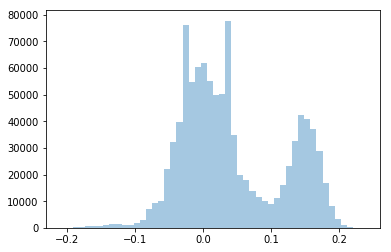

In [107]:
corr123_inv = [
    data3[c].corr(data3['target']) for c in triplet_columns
]

sns.distplot(corr123_inv, kde=False)

In [34]:
corr12_inv_ = pd.Series(corr12_inv, index=train_columns)

In [108]:
corr123_inv_ = pd.Series(corr123_inv, index=triplet_columns)

Filter duplicates and highly correlated features

In [123]:
# corr12_inv_approx = corr12_inv_.apply(lambda x: round(x, 5))
corr12_inv_approx = corr12_inv_

#filtered_corr12_inv_ = corr12_inv_approx[~corr12_inv_approx.duplicated()]
#filtered_corr12_inv_ = filtered_corr12_inv_[filtered_corr12_inv_.abs() > 0.017]
filtered_corr12_inv_ = corr12_inv_approx

In [124]:
filtered_corr12_inv_.shape, corr12_inv_.shape

((132497,), (132497,))

In [125]:
np.min(filtered_corr12_inv_), np.max(filtered_corr12_inv_)

(-0.17592430077456034, 0.20914977808094617)

In [27]:
# sns.distplot(filtered_corr12_inv_[filtered_corr12_inv_.index.str.contains("anatomy_3rd-Ventricle")], kde=False, bins=100)



In [29]:
# "anatomy_lh_superiorparietal_area x 1/(anatomy_3rd-Ventricle)" in filtered_corr12_inv_

In [30]:
# "anatomy_3rd-Ventricle x 1/(anatomy_lh_superiorparietal_area)" in filtered_corr12_inv_

In [35]:
filtered_corr12_inv_[filtered_corr12_inv_ < -0.17].sort_values()

anatomy_rh_caudalanteriorcingulate_thickness / anatomy_3rd-Ventricle   -0.175924
anatomy_lh_parahippocampal_thickness / anatomy_3rd-Ventricle           -0.174813
anatomy_rh_inferiorparietal_area / anatomy_3rd-Ventricle               -0.174039
anatomy_rh_isthmuscingulate_thickness / anatomy_3rd-Ventricle          -0.173304
anatomy_rh_precentral_thickness / anatomy_3rd-Ventricle                -0.172485
anatomy_rh_parahippocampal_thickness / anatomy_3rd-Ventricle           -0.170039
dtype: float64

In [36]:
filtered_corr12_inv_[filtered_corr12_inv_ > 0.185].sort_values()

anatomy_rh_rostralmiddlefrontal_thickness x anatomy_3rd-Ventricle                                                  0.185184
anatomy_3rd-Ventricle x (anatomy_lh_inferiorparietal_thickness + anatomy_rh_inferiorparietal_thickness)            0.185195
anatomy_rh_superiorfrontal_thickness x anatomy_3rd-Ventricle                                                       0.185755
anatomy_3rd-Ventricle x (anatomy_lh_entorhinal_thickness + anatomy_rh_entorhinal_thickness)                        0.185885
anatomy_lh_inferiorparietal_thickness x anatomy_3rd-Ventricle                                                      0.185918
anatomy_3rd-Ventricle x anatomy_lhCortexVol                                                                        0.186465
anatomy_3rd-Ventricle x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)    0.186683
anatomy_lh_rostralmiddlefrontal_thickness x anatomy_3rd-Ventricle                                                  0.187014
anatomy_

In [112]:
corr123_inv_[corr123_inv_ > 0.22].sort_values()

anatomy_SupraTentorialVol / (anatomy_lh_rostralanteriorcingulate_area + anatomy_rh_rostralanteriorcingulate_area) x anatomy_CC_Anterior                                                                       0.220052
(anatomy_Left-Putamen + anatomy_Right-Putamen) / (anatomy_lh_rostralanteriorcingulate_area + anatomy_rh_rostralanteriorcingulate_area) x anatomy_CC_Anterior                                                  0.220137
(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_rostralanteriorcingulate_area + anatomy_rh_rostralanteriorcingulate_area) x anatomy_SupraTentorialVolNotVent                             0.220137
(anatomy_lh_parahippocampal_area + anatomy_rh_parahippocampal_area) / (anatomy_lh_rostralanteriorcingulate_area + anatomy_rh_rostralanteriorcingulate_area) x anatomy_SupraTentorialVolNotVent                0.220406
(anatomy_lh_insula_area + anatomy_rh_insula_area) / (anatomy_lh_rostralanteriorcingulate_area + anatomy_rh_rostralanteriorcingulate_area) x 

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


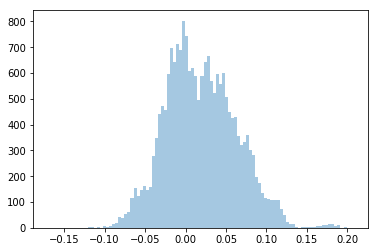

In [35]:

sns.distplot(corr12_inv_[corr12_inv_.index.str.contains(" x ")], kde=False, bins=100)


/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


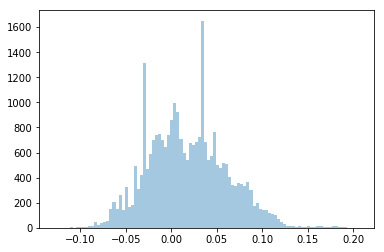

In [36]:

sns.distplot(corr12_inv_[corr12_inv_.index.str.contains(" \+ ")], kde=False, bins=100)


/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


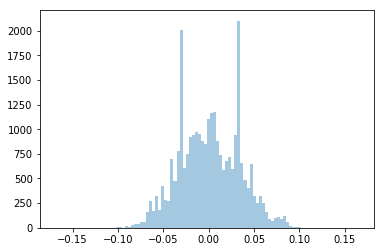

In [37]:

sns.distplot(corr12_inv_[corr12_inv_.index.str.contains(" - ")], kde=False, bins=100)


/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


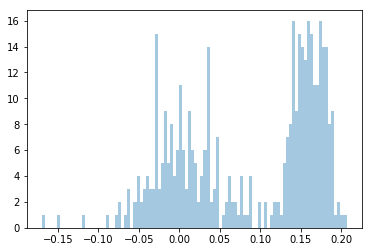

In [38]:

sns.distplot(corr12_inv_[corr12_inv_.index.str.contains("anatomy_3rd-Ventricle")], kde=False, bins=100)


In [40]:
corr12_inv_[(corr12_inv_ > 0.18) & corr12_inv_.index.str.contains("anatomy_3rd-Ventricle /")].sort_values()

anatomy_3rd-Ventricle / (anatomy_lh_rostralanteriorcingulate_area + anatomy_rh_rostralanteriorcingulate_area)    0.181835
dtype: float64

In [48]:
corr12_inv_[(corr12_inv_ > 0.13) & ~corr12_inv_.index.str.contains("anatomy_3rd-Ventricle")].sort_values()

(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)                0.130504
anatomy_CSF x (anatomy_lh_entorhinal_thickness + anatomy_rh_entorhinal_thickness)                                                                        0.130630
anatomy_CSF x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)                                                            0.130670
anatomy_CC_Mid_Anterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)                                                                       0.130870
(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)    0.131093
(anatomy_Left-Lateral-Ventricle + anatomy_Right-Lateral-Ventricle) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)               0.131183
(anatomy_Left-Amygdala + ana

In [37]:
# sns.distplot(filtered_corr12_inv_, kde=False, bins=100)

In [53]:
# cols = [c for c in filtered_corr12_inv_.index]

# corr_ = data2[cols].corr()

# s = pd.Series(corr12_inv_[cols], name="target")
# corr_ = pd.concat([corr_, s], axis=1)

# corr_.loc[:, '1/Q'] = corr_[cols].abs().sum() - corr_['target'].abs()

# corr_ = corr_.sort_values(by='1/Q')

# corr_.sort_values(by="target").tail()

# corr_['1/Q'].min(), corr_['1/Q'].max()

# sns.distplot(corr_['1/Q'], kde=False, bins=100)

# corr_threshold = (corr_['1/Q'].max() + corr_['1/Q'].min()) * 0.5
# corr_threshold

# corr_selected_columns = corr_[corr_['1/Q'] < corr_threshold].index.values.tolist()
# len(corr_selected_columns)

# corr_selected_columns[:10]

In [38]:
corr_selected_columns = filtered_corr12_inv_.index.values.tolist()
corr_selected_columns[:10], len(corr_selected_columns)

(['anatomy_lh_bankssts_area',
  'anatomy_lh_caudalanteriorcingulate_area',
  'anatomy_lh_caudalmiddlefrontal_area',
  'anatomy_lh_cuneus_area',
  'anatomy_lh_entorhinal_area',
  'anatomy_lh_fusiform_area',
  'anatomy_lh_inferiorparietal_area',
  'anatomy_lh_inferiortemporal_area',
  'anatomy_lh_isthmuscingulate_area',
  'anatomy_lh_lateraloccipital_area'],
 132497)

In [39]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

n_jobs=1
seed = 42


class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), 
                                 LogisticRegression(random_state=seed))

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit


def evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results


from problem import get_cv


def original_evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)    
    return results

Check `corr_selected_columns`

In [41]:
import numpy as np

results = evaluation(data2[corr_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.582 +- 0.033 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.567 +- 0.027


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  9.0min finished


```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.672 +- 0.019 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.627 +- 0.020
```

### Feature importance of extracted features

In [42]:
from sklearn.feature_selection import SelectFromModel

pipe = make_pipeline(StandardScaler(), LogisticRegression(C=100, n_jobs=1, random_state=seed))
log_reg = pipe.named_steps['logisticregression']
feature_selection = SelectFromModel(log_reg, prefit=True, threshold="4.0*mean")

In [59]:
pipe.fit(data2[corr_selected_columns], data2['target'])

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [60]:
np_corr_selected_columns = np.array(corr_selected_columns)

In [61]:
selected_corr_columns = feature_selection.transform(np_corr_selected_columns[None, :])[0].tolist()

In [62]:
len(selected_corr_columns), selected_corr_columns[:10], selected_corr_columns[-10:]

(343,
 ['participants_sex',
  '1/(anatomy_lh_rostralanteriorcingulate_area)',
  '1/(anatomy_lh_temporalpole_area)',
  '1/(anatomy_rh_caudalanteriorcingulate_area)',
  '1/(anatomy_rh_inferiorparietal_area)',
  '1/(anatomy_rh_isthmuscingulate_area)',
  '1/(anatomy_rh_parstriangularis_area)',
  '1/(anatomy_rh_rostralanteriorcingulate_area)',
  '1/(anatomy_Left-Lateral-Ventricle)',
  '1/(anatomy_3rd-Ventricle)'],
 ['(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_temporalpole_thickness - anatomy_rh_temporalpole_thickness)',
  '(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_transversetemporal_area - anatomy_rh_transversetemporal_area)',
  '(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_superiortemporal_thickness - anatomy_rh_superiortemporal_thickness)',
  '(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (an

In [83]:
# log_reg = pipe.named_steps['logisticregression']

# coef = log_reg.coef_.ravel()
# positive_coefficients_2 = np.argsort(coef)
# negative_coefficients_2 = np.argsort(coef)

# coef.min(), coef.max(), np.abs(coef).min()

# sns.distplot(coef, kde=False)

# n_top_features = 400

# positive_coefficients = positive_coefficients_2[-n_top_features:]
# negative_coefficients = negative_coefficients_2[:n_top_features]
# interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

# top_corr_selected_columns = np.array(corr_selected_columns)[interesting_coefficients].tolist()



## Train a linear model 

In [63]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

n_jobs=1
seed = 42


class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), 
                                 LogisticRegression(random_state=seed))

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


Check `corr_selected_columns`

In [64]:
import numpy as np

results = evaluation(data2[selected_corr_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.734 +- 0.015 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.672 +- 0.016


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


A reference with feature ^ 2
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.637 +- 0.014 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.604 +- 0.014
```

In [65]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [66]:
import numpy as np

results = evaluation(data2[selected_corr_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.969 +- 0.021
Validation score ROC-AUC: 0.751 +- 0.018 

Training score accuracy: 0.908 +- 0.037
Validation score accuracy: 0.684 +- 0.014


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.9s finished


```
Training score ROC-AUC: 0.969 +- 0.021
Validation score ROC-AUC: 0.751 +- 0.018 

Training score accuracy: 0.908 +- 0.037
Validation score accuracy: 0.684 +- 0.014

```

In [43]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(20, 10))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    if feature_names is not None:
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [44]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

n_jobs=1
seed = 42


class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), 
                                 LogisticRegression(random_state=seed))

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


### Feature importance of Corr selected features

In [45]:
pipe = make_pipeline(FeatureExtractor(), Classifier())
pipe.fit(data2[corr_selected_columns], data2['target'])

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [46]:
log_reg2 = pipe.named_steps['classifier'].clf.named_steps['logisticregression']

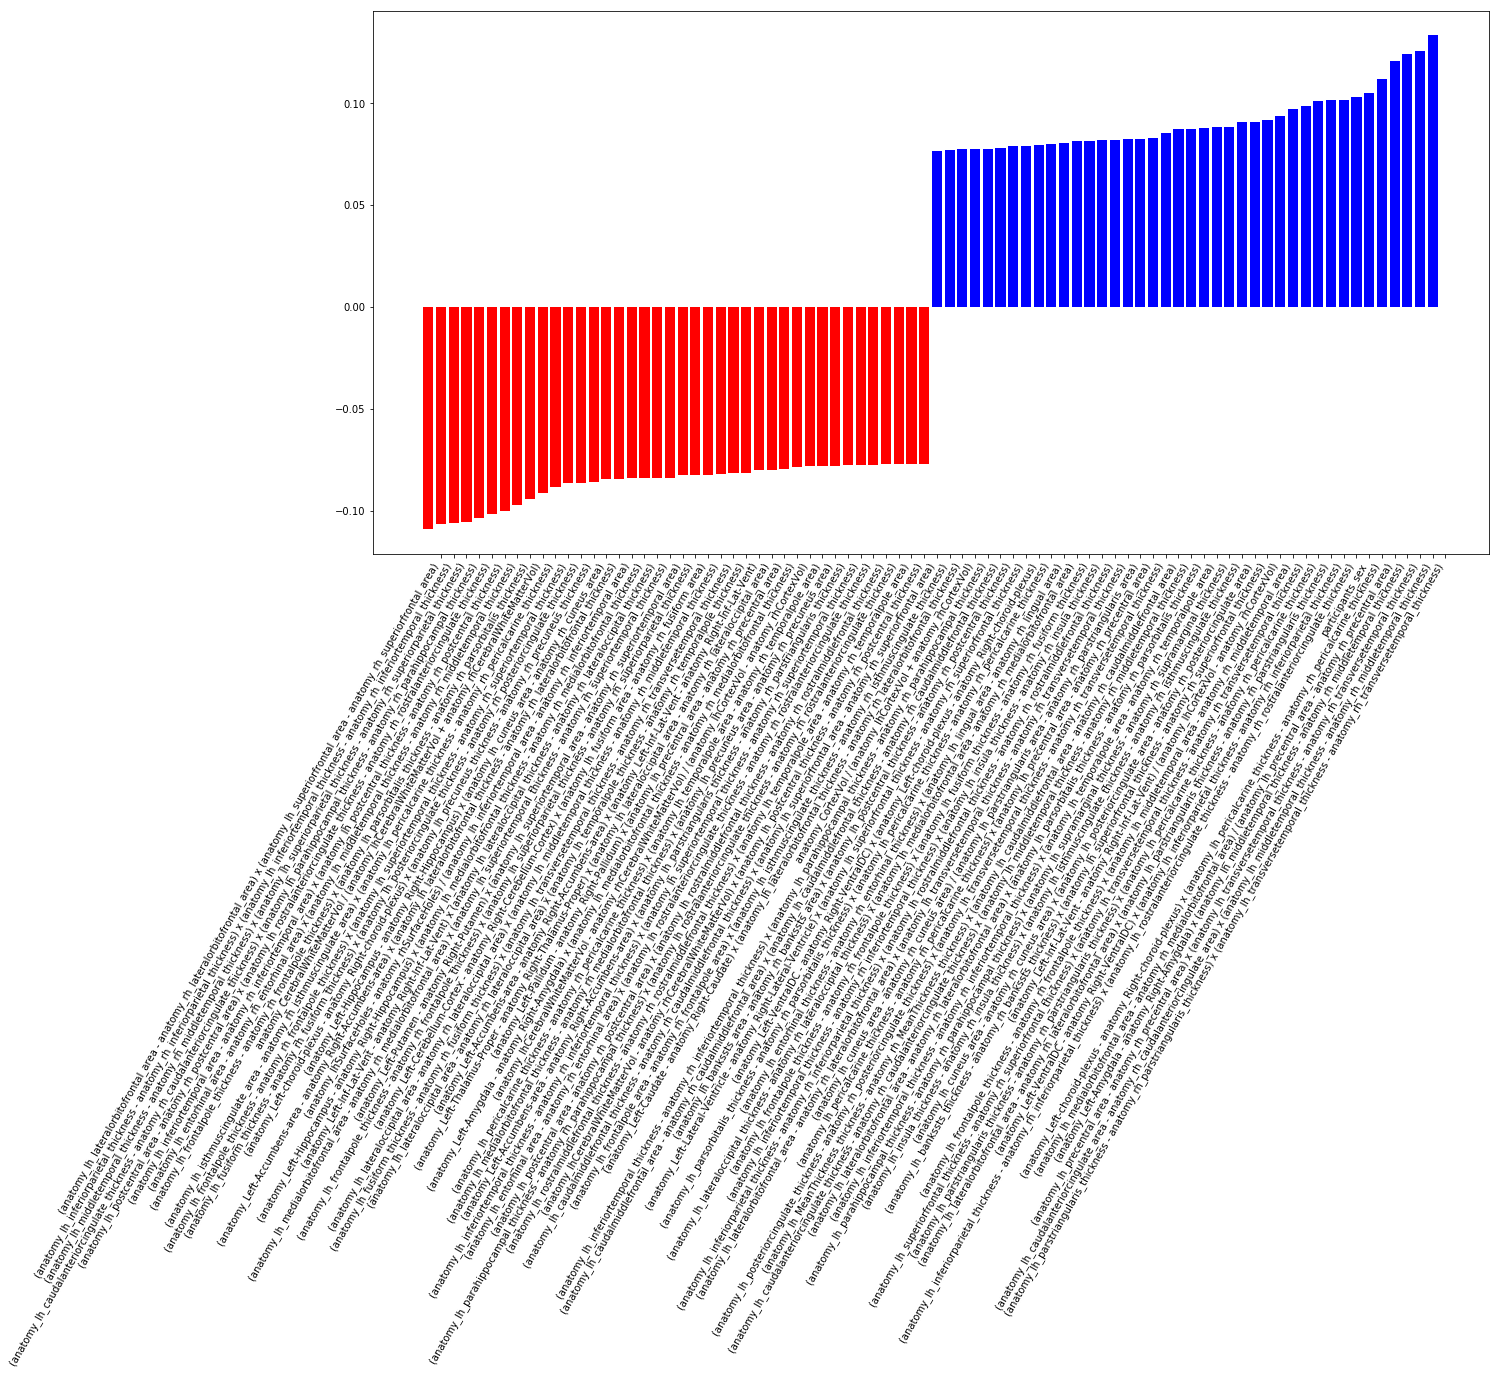

In [47]:
visualize_coefficients(log_reg2, feature_names=corr_selected_columns, n_top_features=40)

In [48]:
coef2 = log_reg2.coef_.ravel()

In [49]:
coef2.min(), coef2.max(), np.abs(coef2).min()

(-0.10917886111079757, 0.13343524581785654, 1.0040365728614716e-07)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


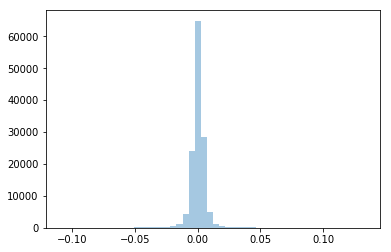

In [50]:
sns.distplot(coef2, kde=False)

In [99]:
neg_threshold = 0.08 * coef2.min()
pos_threshold = 0.075 * coef2.max()
neg_threshold, pos_threshold 

(-0.008734308888863805, 0.010007643436339241)

In [100]:
positive_coefficients = np.where(coef2 > pos_threshold)[0]
negative_coefficients = np.where(coef2 < neg_threshold)[0]

In [101]:
len(positive_coefficients), len(negative_coefficients)

(4253, 4991)

In [102]:
# n_top_features = 400
# positive_coefficients = positive_coefficients_2[-n_top_features:]
# negative_coefficients = negative_coefficients_2[:n_top_features]

interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
top_corr_selected_columns = np.array(corr_selected_columns)[interesting_coefficients].tolist()

In [103]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold

seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [104]:
results = evaluation(data2[top_corr_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.001
Validation score ROC-AUC: 0.709 +- 0.031 

Training score accuracy: 0.998 +- 0.006
Validation score accuracy: 0.658 +- 0.024


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   47.3s finished


**config 2**

```
anatomy select in [1, 2]
corr12_inv_approx = corr12_inv_.apply(lambda x: round(x, 5))

filtered_corr12_inv_ = corr12_inv_approx[~corr12_inv_approx.duplicated()]
filtered_corr12_inv_ = filtered_corr12_inv_[filtered_corr12_inv_.abs() > 0.017]
```

(-0.07284712741455728, 0.07871920503407033)
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.764 +- 0.022 

Training score accuracy: 0.999 +- 0.001
Validation score accuracy: 0.694 +- 0.024
```




**config 1**

```
anatomy select < 2
corr12_inv_approx = corr12_inv_.apply(lambda x: round(x, 5))

filtered_corr12_inv_ = corr12_inv_approx[~corr12_inv_approx.duplicated()]
filtered_corr12_inv_ = filtered_corr12_inv_[filtered_corr12_inv_.abs() > 0.03]
```

(-0.08605396730502125, 0.07733905985162687)
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.765 +- 0.009 

Training score accuracy: 0.999 +- 0.002
Validation score accuracy: 0.697 +- 0.010
```

In [123]:
results = original_evaluation(data2[top_corr_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.844 +- 0.023 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.763 +- 0.030


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   11.1s finished




**config 2**
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.844 +- 0.023 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.763 +- 0.030
```



**config 1**
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.842 +- 0.024 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.762 +- 0.022
```

Try SVM

In [167]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
                
        params = {
            "C": np.logspace(-2, 5, num=12),
            "kernel": ["rbf", "linear"]
        }
        clf = SVC()
        pipe_cv = make_pipeline(StandardScaler(), 
                                GridSearchCV(clf, params, 
                                             n_jobs=8, 
                                             cv=StratifiedKFold(n_splits=5, random_state=seed),
                                             scoring="roc_auc"))
        pipe_cv.fit(X, y)
        best_params = pipe_cv.named_steps['gridsearchcv'].best_params_
        self.clf = make_pipeline(StandardScaler(), SVC(random_state=seed, probability=True, **best_params))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [168]:
results = evaluation(data2[top_corr_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.765 +- 0.013 

Training score accuracy: 0.999 +- 0.004
Validation score accuracy: 0.698 +- 0.016


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished


150 (0.088 Corr threshold)
```
Training score ROC-AUC: 0.970 +- 0.027
Validation score ROC-AUC: 0.765 +- 0.019 

Training score accuracy: 0.918 +- 0.051
Validation score accuracy: 0.700 +- 0.017
```

175 (0.04 Corr threshold)
```
Training score ROC-AUC: 0.986 +- 0.009
Validation score ROC-AUC: 0.812 +- 0.014 

Training score accuracy: 0.946 +- 0.028
Validation score accuracy: 0.732 +- 0.012
```

160 (0.04 Corr threshold)
```
Training score ROC-AUC: 0.985 +- 0.011
Validation score ROC-AUC: 0.811 +- 0.009 

Training score accuracy: 0.944 +- 0.030
Validation score accuracy: 0.733 +- 0.011
```

140 (0.04 Corr threshold)
```
Training score ROC-AUC: 0.982 +- 0.012
Validation score ROC-AUC: 0.811 +- 0.012 

Training score accuracy: 0.937 +- 0.029
Validation score accuracy: 0.732 +- 0.015
```


140 (0.05 Corr threshold)
```
Training score ROC-AUC: 0.979 +- 0.018
Validation score ROC-AUC: 0.797 +- 0.006 

Training score accuracy: 0.933 +- 0.038
Validation score accuracy: 0.717 +- 0.010
```

Print features as a single line

In [90]:
# print("[", end="")
# for f in selected_columns:
#     print("\"{}\"".format(f), end=", ")
# print("]")

In [91]:
# print("[", end="")
# for f in top_corr_selected_columns:
#     print("\"{}\"".format(f), end=", ")
# print("]")